# Imports

In [1]:
%reload_ext autoreload
%autoreload 2

import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
import matplotlib.patheffects as PathEffects
# #import juliet
# import seaborn as sns
# import mplcyberpunk
import numpy as np
import scipy as sp
import pandas as pd
import glob
# import json
# import os
import pickle
# import corner
import pathlib
import itertools
# import batman
# import json
# import re

# from astropy.io import fits, ascii
# from astropy import constants as c
# from astropy import units as u
# from astropy.time import Time
from matplotlib.collections import LineCollection
# #from tqdm import tqdm
# from tqdm.notebook import tqdm
# from datetime import datetime, timedelta
# from dateutil import parser
# from PyAstronomy.pyTiming import pyPeriod

import utils

In [2]:
#####################
# Display and backend
#####################
FIG_LARGE = (11, 8) # Default plot figure size for large figures
FIG_WIDE = (11, 5)    
%config InlineBackend.figure_format = "retina" # Crisp retina display on macs
# Qt5 backend for interactive plotting
%matplotlib qt5 

################
# Theme settings
################
def set_theme(notebook_mode="dark"):
    plt.style.use("default") # Reset to default before layering on any changes
    sns.set(palette="Paired", color_codes=True, context="talk")

    if notebook_mode.lower() == "paper":
        sns.set_style('ticks')
        params = {
            # xticks
            "xtick.top":False,
            "xtick.direction":"out",
            "xtick.major.size":5,
            "xtick.minor.visible":False,

            # yticks
            "ytick.right":False,
            "ytick.direction":"out",
            "ytick.major.size":5,
            "ytick.minor.visible":False,

            # pallete
            "axes.prop_cycle":mpl.cycler(color=[
                "#fdbf6f", # Yellow
                "#ff7f00", # Orange
                "#a6cee3", # Cyan
                "#1f78b4", # Blue
                "#956cb4", # Purple
                "#029e73", # Green
                "#c44e52", # Red
            ]),
        }
        #sns.set_style("ticks", tick_params)
        #params = {
        #    "axes.formatter.limits":(-3, 7),
        #    #"axes.spine.right":False,
        #    "xtick.major.size":2,
        #}
        plt.rcParams.update(params)

    elif notebook_mode.lower() == "dark":
        sns.set(palette="colorblind", color_codes=True, context="talk")
        plt.style.use("cyberpunk")
        # Re-order color cycle
        params = {
            "axes.prop_cycle":mpl.cycler(color=[
               "#fdbf6f", # Yellow
                "#ff7f00", # Orange
                "#a6cee3", # Cyan
                "#1f78b4", # Blue
                "thistle",
                "#956cb4", # Purple
                "#029e73", # Green
                "#c44e52", # Red
            ]),
        }
        plt.rcParams.update(params)

    else:
        plt.style.use("default")
    
HOURS = mdates.HourLocator() # For UTC plots with ticks every hour
pd.set_option("display.max_rows", None, "display.max_columns", None)

from tqdm import tqdm_notebook as tqdm

set_theme("dark")

ImportError: Failed to import any qt binding

In [3]:
sns.palplot(sns.palettes.color_palette('muted'))

In [6]:
print(sns.palettes.color_palette().as_hex())

['#f5d300', '#d55e00', '#08f7fe', '#0173b2', '#029e73']


## Scale Height

In [ ]:
print()

In [ ]:
def get_Teq(Ts=None, albedo=None, aRs=None, Rs=None, a=None):
    if (aRs is None):
        return Ts * (1 - albedo)**0.25 * (0.5*Rs/a)**0.5
    else:
        return Ts * (1 - albedo)**0.25 * (0.5/aRs)**0.5

def get_H(
    Tp=None,
    Mp=None,
    Rp=None,
    Ts=None,
    Rs=None,
    mu=None,
    albedo=None,
    aRs=None,
    a=None,
    RpRs=None,
):
    if isinstance(Mp, u.Quantity):
        G_Mp = c.G * Mp
    else:
        # Default to Jupiter mass
        G_Mp = c.GM_jup * Mp
    if (RpRs is None) and (Rp is not None):
        g = G_Mp / Rp**2
    else:
        g = G_Mp / (RpRs**2 * Rs**2)
    if Tp is None:
        Tp = get_Teq(Ts=Ts, albedo=0, aRs=aRs, Rs=Rs, a=a)
    return c.k_B * Tp / (mu * g), Tp

def get_depth(Tp=None,
              Mp=None,
              Rp=None,
              Ts=None,
              Rs=None,
              mu=None,
              H=None,
              aRs=None,
              a=None,
              RpRs=None,
):
    if H is None:
        H, Tp = get_H(Tp=Tp, Mp=Mp, Rp=Rp, Ts=Ts, Rs=Rs, mu=mu, aRs=aRs, a=a, RpRs=RpRs)
    if RpRs is None:
        Delta_D =  2 * H * Rp / Rs**2, H, Tp
    else:
        Delta_D =  2 * H * RpRs/Rs, H, Tp
    return Delta_D

D, H, Tp = get_depth(
    #Rp=1.036*u.R_jup,
    mu=2*u.Da,
    Mp=1.97*u.M_jup,
    Ts=5734*u.K,
    Rs=1.1858169*u.R_sun,
    RpRs = 0.1113,
    aRs=4.26,
    #a=0.01528*u.AU,
    #Tp=1440*u.K,
)

print(f'Tp = {Tp.cgs:.3f}')
print(f'H = {H.to("km"):.3f},')
n = 5
print(f'Delta D = {n * D.cgs * 1e6:.3f} ppm at {n} scale heights')

# Raw data inspection

In [ ]:
fpaths = glob.glob("./data/HATP23/ut160720/ift*c1.fits")
#fpaths = glob("./data/HATP23/ut160621/ift*c1.fits")

object_names = []
for fpath in fpaths:
    with open(fpath, "rb") as f:
        header = fits.open(f, de)[0].header
        name = header["OBJECT"]
        object_names.append(name)
        
len(object_names)

In [ ]:
# Config:
images_dir = '../atmospheres_meeting/figs'
result_grid_filename = '/Users/mango/Desktop/grid.png'
result_figsize_resolution = 40 # 1 = 100px

images_list = glob.glob(f"{images_dir}/*raw_lc.png")

# Create plt plot:
fig, axes = plt.subplots(5, 2, figsize=(8, 40))
axes = axes.flatten()

for ax, img in zip(axes, images_list):
    plt_image = plt.imread(img)
    plt_image = np.array(Image.open(img))
    ax.imshow(plt_image, aspect="auto")
    ax.axis("off")
    
fig.tight_layout()
plt.subplots_adjust(wspace=.0, hspace=.0)
#plt.savefig("/Users/mango/Desktop/grid.png", dpi=250, bbox_inches="tight", pad_inches=0)

## File stats

In [ ]:
data_dir = "Projects/HATP26b/data/ut190313"
date = data_dir.split('/')[-1]
fpaths = np.array(sorted(glob.glob(f'{data_dir}/ift*c1.fits')))
filenames = []
objects = []
slits = []
airmasses = []
file_info = {}
for fpath in tqdm(fpaths):
    header = utils.fits_header(fpath)
    #header = fits.getheader(fpath)
    #print(header['OBJECT'])
    if header is not None:
        file_info[header['FILENAME'].split('c')[0]] = {
            'UT Date':         header['UT-DATE'],
            'UT Time (start)': header['UT-TIME'],
            'UT Time (end)':   header['UT-END'],
            'Exposure (s)':    header['EXPTIME'],
            'Object':          header['OBJECT'],
            'Exposure type':   header['EXPTYPE'],
            'RA':              header['RA'],
            'Dec':             header['DEC'],
            'Mask':            header['SLITMASK'],
            'Filter':          header['FILTER'],
            'Disperser':       header['DISPERSR'],
            'Airmass':         header['AIRMASS'],
            'Seeing':          header['G-SEEING'],
            'Binning':         header['Binning'],
            'Speed':           header['Speed'],
            'Subrastr':           header['SUBRASTR'],
            #'File':            header['FILENAME'],
        }
    
df_file_info = pd.DataFrame.from_dict(file_info, orient="index")
df_file_info.index.name = "root"
#sci_mask = df_file_info['Object'].str.contains('science')
#df_file_info[sci_mask]#.info()
#date = data_dir.split('/')[-1]
df_file_info.to_csv(
    f"{data_dir}/../logs/night_log_{date}.csv",
    #index_label = "root",
)
#df_file_info.to_csv(f'./projects/HATP26b/night_log_{date}.txt', index=False)
#df_file_info.query('Object.str.contains("sci")')

In [ ]:
df_file_info.head()

In [ ]:
pd.read_csv(f"{data_dir}/../logs/night_log_{date}.csv").head()

In [ ]:
df_sci = df_file_info[df_file_info["Object"].str.contains("sci")]

In [ ]:
df_sci.shape

In [ ]:
cNames

In [ ]:
AM = df_sci['Airmass'].to_numpy()
idxs = range(len(AM))
idx_min = np.argmin(AM)

def plot_ann(ax, x, y):
    ax.plot(x, y, 'ro')
    ax.annotate(f'{y:.3f}', xy=(x, y+0.02))

fig, ax = plt.subplots()


ax.plot(np.array(phase)*24, AM[idxs_used])
#plot_ann(ax, idxs[0], AM[0])
#plot_ann(ax, idxs[idx_min], np.min(AM))
#plot_ann(ax, idxs[-1], AM[-1])

ax.set_xlabel('Phase')
ax.set_ylabel('Airmass')
ax.set_title('HAT-P-26 science frames')

#utils.savefig('projects/HATP26b/journal/figures/data_inspection/airmass.pdf')

In [ ]:
phase

In [ ]:
data_dir = 'data/HATP23'
data_dict = {
    'transit_1':
        {
            'path':f'{data_dir}/ut160621',
            'ift':'1116',
            'sky_ap':20,
        },
#
    'transit_2':
        {
            'path':f'{data_dir}/ut170609',
            'ift':'0183',
            'sky_ap':25,
        },
    'transit_3':
        {
            'path':f'{data_dir}/ut180603',
            'ift':'0076',
            'sky_ap':25,
        },
    'transit_4':
        {
            'path':f'{data_dir}/ut180620',
            'ift':'4444',
            #'ift':'4050',
            'sky_ap':25,
        },
    'transit_5':
        {
            'path':f'{data_dir}/ut180821',
            'ift':'0200',
            #'ift':'0000',
            'sky_ap':25,
        },
}

In [ ]:
data_dir = 'data/HATP26'
data_dict = {
    'transit_1':
    {
        'path':f'{data_dir}/ut190313',
        'ift':'1310',
        'sky_ap':25,
    }
}

In [ ]:
for transit, transit_info in data_dict.items():
    dirpath = transit_info['path']
    fname = f"ift{transit_info['ift']}"
    sky_ap = transit_info['sky_ap']
    fig, im = utils.plot_chips(
        dirpath, fname, vmin=0, vmax=2_000, sky_ap=25, spec_ap=12,
    )
    #fig.set_size_inches(8, 11)
    #fig.colorbar(im, ax=axes.flatten(), aspect=30, label='counts')
    #fig.subplots_adjust(wspace=0.1, hspace=0.01)
    #plt.savefig("/Users/mango/Desktop/test.png", bbox_inches="tight")
    plt.savefig(
       f'projects/HATP26b/journal/figures/{transit}_raw_frame.png',
        bbox_inches="tight",
        dpi=250
    )

In [ ]:
axes.flatten()

In [ ]:
fig, axes = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(8, 11))

for i, ax in enumerate(axes.flatten()):
    im = ax.imshow(np.random.rand(2048, 1024))
    if i <= 3:
        ax.set_title('title')
    else:
        ax.set_xlabel('title')
    
#cbar_ax = fig.add_axes([0.91, 0, 0.05, 0.7])
#fig.colorbar(im, cax=cbar_ax)
#fig.colorbar(im, ax=axes.ravel().tolist(), aspect=30, label='counts')
fig.subplots_adjust(wspace=0.1, hspace=0.01)

In [ ]:
sns.palplot(sns.color_palette())

### Chips Movie

In [49]:
#plt.switch_backend("Agg")
set_theme("dark")

# base_dir = "/home/mango/data/WASP50/wasp50_ut"
# data_dict = { 
#    "131219":{"first":"ift0026", "spec_ap":15, "sky_ap":25, "vmax":1_000},
#    "150922":{"first":"ift0503", "spec_ap":15, "sky_ap":25, "vmax":1_000},
#    "150927":{"first":"ift0543", "spec_ap":15, "sky_ap":25, "vmax":1_000},
#     "161211":{"first":"ift0046", "spec_ap":24, "sky_ap":42, "vmax":5_000},
# }

# base_dir = "/home/mango/data/WASP80/ut"
# data_dict = {
#     #"140726_27":{"first":"ift0019", "spec_ap":12, "sky_ap":18, "vmax":1_000},
#     #"140904_05":{"first":"ift0086", "spec_ap":12, "sky_ap":18, "vmax":1_000},
#     "160712_13":{"first":"ift0071", "spec_ap":16, "sky_ap":18, "vmax":1_000},
# }

# base_dir = "/home/mango/data/HATP26/ut"
# data_dict = {
#     "190313":{"first":"ift1059", "spec_ap":15, "sky_ap":25, "vmax":1_000},
#     #"210323":{"first":"ift0104", "spec_ap":15, "sky_ap":25, "vmax":1_000},

# }


# base_dir = "/home/mango/data/WASP16/ut"
# data_dict = {
#     "180506_07":{"first":"ift0009", "spec_ap":15, "sky_ap":25, "vmax":25_000}
# }

base_dir = "/home/mango/data/WASP107/ut"
data_dict = {
    "200302":{"first":"ift0441", "spec_ap":15, "sky_ap":25, "vmax":1_000},
    #"210326":{"first":"ift0441", "spec_ap":15, "sky_ap":25, "vmax":1_000},
}

for date, data in tqdm(data_dict.items()):
    dirpath = f"{base_dir}{date}"
    fig, im, grid = utils.plot_chips(
        dirpath,
        data["first"],
        target = base_dir.split('/')[4],
        vmin = 0,
        vmax = data["vmax"],
        spec_ap = data["spec_ap"],
        sky_ap = data["sky_ap"],
        #llama = True,
    )
    
#     for ax in grid:
#         print(ax.get_position())
    
    fig.suptitle(f"ut{date}")
    #utils.savefig(f"/home/mango/Desktop/2d_spectra_{date}.png")
    #plt.close(fig)

<ipython-input-49-940b230339ce>:38: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for date, data in tqdm(data_dict.items()):


  0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
utils.fits_header("/home/mango/data/WASP107/ut200302/ift0007c1.fits")

SIMPLE  =                    T                                                  
BITPIX  =                   16                                                  
NAXIS   =                    2                                                  
NAXIS1  =                 1088                                                  
NAXIS2  =                 2112                                                  
BSCALE  =           1.00000000         / real=bzero+bscale*value                
BZERO   =       32768.00000000                                                  
BUNIT   = 'DU/PIXEL'                                                            
ORIGIN  = 'LCO/OCIW'                                                            
OBSERVER= 'Chima McGruder'             / observer name                          
TELESCOP= 'Baade_Mag_1'                / telescope                              
SITENAME= 'LCO'                                                                 
SITEALT =                 24

### Chips Movie all dates

In [ ]:
plt.switch_backend("Agg")
frames_all_nights = []
for night in sorted(glob.glob("./data/WASP39/ut*")):
    frame_date = sorted(glob.glob(f"{night}/pngs/*.png"))
    frames_all_nights.append(frame_date)

# Get longest night for padding
max_night_length = len(max(frames_all_nights, key=len))

# Pad shorter nights with last frame for each night
for night in frames_all_nights:
    night += [night[-1]]*(max_night_length - len(night))

# Combine
#for frames_all in zip(*frames_all_nights):
#    for frame in frames_all:
#        print(frame)
    #print("\nMoving on to next frame in all datasets")

In [ ]:
plt.switch_backend("Agg")
for i, frame in tqdm(enumerate(zip(*frames_all_nights)), total=max_night_length):
    # Create plt plot:
    fig, axes = plt.subplots(2, 5, figsize=(40, 18))

    for ax, img in zip(axes.flat, frame):
        plt_image = np.array(Image.open(img))
        ax.imshow(plt_image, aspect="auto")
        ax.axis("off")

    fig.tight_layout()
    plt.subplots_adjust(wspace=.0, hspace=.0)
    plt.savefig(f"../atmospheres_meeting/figs/chips/frames/frame_{i:03}.png", 
                bbox_inches="tight", pad_inches=0)
    plt.close()

In [ ]:
import itertools

In [ ]:
frames_all_nights = []
for night in sorted(glob.glob("./data/HATP23/ut*")):
    frame_date = sorted(glob.glob(f"{night}/pngs/*.png"))
    frames_all_nights.append(frame_date)

In [ ]:
frames_all_nights = []
for night in sorted(glob.glob("./data/HATP23/ut*")):
    frame_date = sorted(glob.glob(f"{night}/pngs/*.png"))
    frames_all_nights.append(frame_date)

# Get longest night for padding
max_night_length = len(max(frames_all_nights, key=len))

# Pad shorter nights with last frame for each night
for night in frames_all_nights:
    night += [night[-1]]*(max_night_length - len(night))

# Combine
#for frames_all in zip(*frames_all_nights):
#    print(frames_all)
    #for frame in frames_all:
    #    print(frame)
    
    #print("\nMoving on to next frame in all datasets")

## Aperture

In [200]:
fpath = "/home/mango/data/HATP26/ut190313/ift1335c2.fits"
fig, axes, data = utils.plot_aperture(fpath)

(2112, 1088)


## 2D Spectra over time

In [ ]:
spectra = []
for fpath in fpaths_sci:
    chip_data = utils.fits_data(fpath)
    x_l, x_r = 190, 206
    #x_l, x_r = 688, 691
    y_d, y_u = 0, chip_data.shape[0]
    spectra_n = chip_data[y_d:y_u, x_l:x_r]
    #spectra_n = np.max(spectra_n, axis=1)
    spectra.append(spectra_n)
    
spectra = np.concatenate(np.array(spectra), axis=1).T

In [18]:
data_dir = "../data/WASP39/ut190315"
chip_num = 5
x_l, x_r = 190, 206
object_name = "w39bs science"

#data_dir = "../data/WASP43/ut180603"
#chip_num = 8
#x_l, x_r = 688, 691
#object_name = "science"

fig, ax, spectra = utils.plot_spec2d(data_dir, chip_num, x_l, x_r, object_name)

# tokens = data_dir.split("/")
# target, date = tokens[2], tokens[3]
# fname = f"spectra_2D_{target}_{date}"
# fig.savefig(f"/Users/mango/Desktop/{fname}.pdf", bbox_inches="tight")

AttributeError: module 'utils' has no attribute 'plot_spec2d'

In [ ]:
fig, ax = plt.subplots()
im = ax.imshow(spectra, vmin=0, vmax=30_000)
fig.colorbar(im, ax=ax)
ax.set_aspect("equal")
#fig.savefig(f"/Users/mango/Desktop/{fname}.pdf", bbox_inches="tight")

## Quicklook Light Curves

In [50]:
fpath = "/home/mango/data/WASP107/ut210326/WASP107_WLC_OTG.pkl"
target = "w107"
data = utils.load_pickle(fpath)
name_target = [s for s in data["fluxes"].keys() if target in s][0]

fig, ax = plt.subplots(figsize=FIG_WIDE)

# Plot divided LCs
time = data["time"]
flux_ratio = data["flux_ratio"]
flux_target = data["fluxes"][name_target]
flux_comps = []
for obj, flux in data["fluxes"].items():
    if obj != name_target:
        flux_comps.append(flux)
        flux = flux_target / flux
        #ax.plot(time, flux/np.median(flux), '.', label=obj)
        ax.plot(flux/np.median(flux), '-o', mew=0, alpha=0.5, lw=0.5, label=obj)
        
# Plot sum LC
flux_sum_comps = np.sum(flux_comps, axis=0)
flux = flux_target / flux_sum_comps
flux_norm = flux / np.median(flux)
#ax.plot(time, flux / np.median(flux), 'lightgrey', lw=5, label="all")
ax.plot(flux_norm, '-o', color='lightgrey', lw=2, label="all")
#ax.legend(ncol=int((len(flux_comps)+1)/2), frameon=True)
ax.legend()
delta = 1.0 - np.min(flux_norm)
RpRs = np.sqrt(delta)
label = rf"$R_\mathrm{{p}}/R_\mathrm{{s}} \approx {RpRs:.3f}$"
ax.annotate(label, xy=(0.9, 0.1), xycoords="axes fraction", ha="center")
ax.set_xlabel("Science frame")
ax.set_ylabel("Normalized Flux")
#ax.set_ylim(0.978, 1.04)
fig.tight_layout()

ValueError: operands could not be broadcast together with shapes (422,) (421,) 

In [13]:
data["fluxes"].keys()

dict_keys(['w107_2', 'com01_1', 'com02_4', 'com03_6'])

In [56]:
set_theme("dark")

base_dir = "/home/mango/data/WASP107"
# dates = {
#     "131219": Time("2013-12-19T03:22:00"),
#     "150922": Time("2015-09-23T08:46:00"),
#     "150927": Time("2015-09-27T06:37:00"),
#     "161211": Time("2016-12-12T03:03:00"),
# }
# dates = {
#     "190313": [
#         Time("2019-03-14T04:39:00"),
#         Time("2019-03-14T05:52:00"),
#         Time("2019-03-14T07:06:00"),
#     ],
#     "210323": [
#         Time("2021-03-24T05:32:00"),
#         Time("2021-03-24T06:46:00"),
#         Time("2021-03-24T08:00:00"),
#     ],
# }
dates = {
    "210326": [
        Time("2021-03-27T05:08:00.0"),
        Time("2021-03-27T06:30:00.0"),
        Time("2021-03-27T07:52:00.0"),
    ]
}

P = 5.72 * u.day

fig, axes = plt.subplots(
    1,
    1,
    figsize=FIG_LARGE,
    sharex=True,
    sharey=True,
)

if isinstance(axes, mpl.axes._subplots.Axes):
    axes = [axes]
else:
    axes = axes.flat

p = 0.14434
p_err = 0.00018
delta = p**2
delta_min = (p - p_err)**2
delta_max = (p + p_err)**2


for i, (ax, (date, ts)) in enumerate(zip(axes, dates.items())):
    fpath = f"{base_dir}/ut{date}/WASP107_WLC_OTG.pkl"
    data = utils.load_pickle(fpath)

#     t, f = data["time"], data["flux_ratio"]
    t, f = data["time"], data["fluxes"]["w107_2"] / data["fluxes"]["com01_1"]
            
    phase_ing = utils.get_phases(ts[0], P, ts[1])
    phase_mid = utils.get_phases(t, P, ts[1])
    phase_egr = utils.get_phases(ts[2], P, ts[1])
    
    ax.plot(phase_mid, f / np.median(f), '.', color=f"C{i}", label=date)
    
    ax.axvline(phase_ing, c="darkgrey", ls='--', lw=1)
    ax.axvline(1 + phase_egr, c="darkgrey", ls='--', lw=1)
    
    ax.axhline(1 - delta, c='g')
    ax.axhspan(
        1.0 - delta_min, 1.0 - delta_max,
        lw=0, color='g', alpha=0.5,
    )
    ax.annotate(
        f"ut{date}", (0.1, 0.9), xycoords="axes fraction",
        color = f"C{i}",
    )
    #ax.legend()

#ax.legend()
#fig.legend(ncol=len(dates), loc="upper center", frameon=True)
fig.text(0.535, -0.005, "Phase", ha="center")
fig.text(-0.005, 0.535, "Relative flux", va="center", rotation="vertical")
#ax.set_ylim(0.97, 1.03)
#ax.set_xlabel("Time (UT)")
#ax.set_ylabel("Normalized flux")
fig.suptitle("WASP-107b quick-look")
fig.tight_layout()

utils.savefig("/home/mango/Desktop/raw_lc_w107.png", dpi=250)

In [154]:
ts

[<Time object: scale='utc' format='isot' value=2021-03-24T05:32:00.000>,
 <Time object: scale='utc' format='isot' value=2021-03-24T06:46:00.000>,
 <Time object: scale='utc' format='isot' value=2021-03-24T08:00:00.000>]

In [162]:
ts[2] - ts[1]

<TimeDelta object: scale='tai' format='jd' value=0.05138888888888887>

In [165]:
utils.get_phases(ts[2], P, ts[1])

<Quantity -0.98786429>

In [65]:
set_theme("dark")

base_dir = "/home/mango/data/HATP26"
# dates = {
#     "131219": Time("2013-12-19T03:22:00"),
#     "150922": Time("2015-09-23T08:46:00"),
#     "150927": Time("2015-09-27T06:37:00"),
#     "161211": Time("2016-12-12T03:03:00"),
# }
dates = {
    "190313": Time("2019-03-14T05:52:00"),
    "210323": Time("2021-03-24T06:46:00"),
}
P = 4.234520 * u.day

fig, axes = plt.subplots(
    2,
    1,
    figsize=FIG_LARGE,
    sharex=True,
    sharey=True,
)

if isinstance(axes, mpl.axes._subplots.Axes):
    axes = [axes]
else:
    axes = axes.flat

p = 0.0737
p_err = 0.0012
delta = p**2
delta_min = (p - p_err)**2
delta_max = (p + p_err)**2


for i, (ax, (date, t0)) in enumerate(zip(axes, dates.items())):
    fpath = f"{base_dir}/ut{date}/HATP26_WLC_OTG.pkl"
    data = utils.load_pickle(fpath)

    t, f = data["time"], data["flux_ratio"]
    print(t0)
    phase = utils.get_phases(t, P, t0)
    ax.plot(phase, f / np.median(f), '.', color=f"C{i}", label=date)
    ax.axhline(1 - delta, c='g')
    ax.axhspan(
        1.0 - delta_min, 1.0 - delta_max,
        lw=0, color='g', alpha=0.5,
    )
    ax.annotate(
        date, (0.9, 0.9), xycoords="axes fraction",
        color = f"C{i}",
    )
    #ax.legend()

#ax.legend()
#fig.legend(ncol=len(dates), loc="upper center", frameon=True)
fig.text(0.535, -0.005, "Phase", ha="center")
fig.text(-0.005, 0.535, "Normalized flux", va="center", rotation="vertical")
#ax.set_ylim(0.97, 1.03)
#ax.set_xlabel("Time (UT)")
#ax.set_ylabel("Normalized flux")
fig.suptitle("HAT-P-26b")
fig.tight_layout()

#utils.savefig("/home/mango/Desktop/raw_lcs.png", dpi=250)

2019-03-14T05:52:00.000
2021-03-24T06:46:00.000


## IMACS Photometry

In [ ]:
data_dict = {
    'Transit 2':
    f'{data_dir}/ut170609_a15_25_noflat/LCs_hp23_{binsize}.pkl',

    'Transit 3':
    f'{data_dir}/ut180603_a15_25_noflat/LCs_hp23_{binsize}.pkl',
}

fig, axes = plt.subplots(2, 1, figsize=FIG_LARGE)

objs = ["HATP23b", "comp4", 'comp5']
colors = ["C5", "C0", "C1"]
for ax, (transit_name, transit_path) in zip(axes.flat, data_dict.items()):
    data = utils.pkl_load(transit_path)
    time = Time(data["t"], format="jd")# - 2450000
    wavs = data["optimal spectra"]["wavelengths"]
    wav_low_idx = np.where(wavs == 5000)[0][0]
    wav_high_idx = np.where(wavs == 9000)[0][0]
    wavs_int = wavs[wav_low_idx:wav_high_idx+1]
    for obj, c in zip(objs, colors):
        f = data["optimal spectra"][obj][:,wav_low_idx:wav_high_idx+1].sum(axis=1)
        ax.plot_date(time.plot_date, f/np.max(f), '.', label=obj, color=c)

        ax.legend(ncol=3, loc=4)
        ax.set_xlabel("Time (UTC)")
        ax.set_ylabel("$F / F_\mathrm{max}$")
        ax.set_title(transit_name)

    #ax.plot_date(time.plot_date, data["oLC"]/np.max(data["oLC"]), c='r')
fig.tight_layout()

In [ ]:
data.keys()

In [ ]:
plt.figure()
plt.plot(data["oLC"][:, 1], '.')

# ASAS-SN Photometry

#### Raw data

In [ ]:
set_theme("paper")
fpaths = [
    'projects/HATP23b/asas-sn_hatp23.csv',
    'projects/HATP23b/asas-sn_comp5.csv',
    'projects/HATP23b/asas-sn_comp4.csv',
    'projects/HATP23b/asas-sn_comp7.csv'
]

fig, ax = plt.subplots(figsize=FIG_WIDE)
for fpath in fpaths:
    df = pd.read_csv(fpath, parse_dates=["UT Date"], date_parser=utils.myparser)

    #display(df.head())
    name = fpath.split('/')[-1]
    df.set_index(["UT Date"], inplace=True)
    grouped = df.groupby('Filter')
    for (k, g) in grouped:
        if k=='V':
            ax.plot(g['flux(mJy)'], marker='.', lw=0, label=name)
    
mid_transit_times = {
        'Transit 1': '2016-06-22 08:18:00',
        'Transit 2': '2017-06-10 07:05:00',
        'Transit 3': '2018-06-04 07:24:00',
        'Transit 4': '2018-06-21 06:56',
        'Transit 5': '2018-08-22 03:30:00',
    }
p_kwargs = {'ls': '--', 'c': 'grey', 'lw':1.0}
for transit_name, t0 in mid_transit_times.items():
    t_mid = parser.parse(t0)
    ax.axvline(t_mid, **p_kwargs)
    ax.text(t_mid, 20.0, transit_name, ha='right', rotation=90.0)

ax.legend(loc=2, frameon=True, fontsize=12, bbox_to_anchor=(1, 1))
#ax.set_title(fpath)
ax.set_ylim(0, 60)
ax.set_xlabel('Date')
ax.set_ylabel('Flux (mJy)')
fig.autofmt_xdate(rotation=45)
fig.tight_layout()

In [ ]:
def reject_outliers(data, m=2):
    outlier_mask = abs(data - np.mean(data)) > m * np.std(data)
    return data[~outlier_mask], outlier_mask

In [ ]:
fpath = "projects/HATP23b/asas-sn_hatp23.csv"
df = pd.read_csv(fpath, parse_dates=["UT Date"], date_parser=utils.myparser)
df_V = df.groupby("Filter").get_group("V")
t = (df_V["HJD"] - 2.457e6).values
f = df_V["flux(mJy)"].values
plt.figure()
plt.plot(t[142:], '.')

In [ ]:
f_filtered, outlier_mask = reject_outliers(f)

fig, axes = plt.subplots(2, 1, figsize=FIG_LARGE)
ax_top, ax_bottom = axes

#ax.plot(t, f, '.')
#ax.plot(t[outlier_mask], f[outlier_mask], 'ro', alpha=0.5)

idxs_dict = {
    "asas-sn_hatp23.csv":{
        "idx_start":54,
        "idxs_seasons":
            [slice(0, 203), slice(204, 377), slice(412, 516)]
    },
    "asas-sn_comp4.csv":{
        "idx_start":7,
        "idxs_seasons":
            [slice(0, 203), slice(204, 377), slice(419, 531)]
    },
    "asas-sn_comp5.csv":{
        "idx_start":7,
        "idxs_seasons":
            [slice(0, 203), slice(204, 371), slice(418, 530)]
    },
    "asas-sn_comp7.csv":{
        "idx_start":142,
        "idxs_seasons":
            [slice(0, 202), slice(204, 377), slice(419, 531)]
    },
}

target_file = fpath.split('/')[-1]
idx_start = idxs_dict[target_file]["idx_start"]
time_global, flux_global = t[~outlier_mask][idx_start:], f[~outlier_mask][idx_start:]

idxs_seasons = idxs_dict[target_file]["idxs_seasons"]

ax_top.plot(time_global, flux_global, 'ko', alpha=0.25, mew=0)
# Compute the GLS periodogram with default options.
clp = pyPeriod.Gls((time_global, flux_global))
freq_max, freq_max_err = clp.hpstat["fbest"], clp.hpstat["f_err"]
P_max, P_max_err = 1.0/freq_max, clp.hpstat["Psin_err"]
label = f"$P_\mathrm{{max}} = {P_max:.3f} \pm {P_max_err:.3e}$"
ax_bottom.semilogx(1.0/clp.freq, clp.power, label=label)
print(f"> Global")
print(f"{fpath}")
clp.info()
print()

# Calculate sine wave associated with 'best-fit' frequency
bestSine_global = clp.sinmod(time_global)
ax_top.plot(time_global, bestSine_global, label="Global")
ax_top.legend(fontsize=12)

for i, idxs_season in enumerate(idxs_seasons, start=1):
    time, flux = time_global[idxs_season], flux_global[idxs_season]
    #ax.plot(time, flux, '.')

    # Compute the GLS periodogram with default options.
    clp = pyPeriod.Gls((time, flux))
    
    # and plot power vs. period.
    freq_max, freq_max_err = clp.hpstat["fbest"], clp.hpstat["f_err"]
    P_max, P_max_err = 1.0/freq_max, clp.hpstat["Psin_err"]
    label = f"$P_\mathrm{{max}} = {P_max:.3f} \pm {P_max_err:.3e}$"
    ax_bottom.semilogx(1.0/clp.freq, clp.power, label=label)
    ax_bottom.set_xlabel("Period (days)")
    ax_bottom.set_ylabel("Power")
    
    # Calculate sine wave associated with 'best-fit' frequency
    bestSine = clp.sinmod(time)
    ax_top.plot(time, bestSine, label=f"Season {i}")
    idxs_mid = len(time) // 2
    phot_var = np.var(flux)
    ax_top.annotate(
        f"$\sigma^2 = {phot_var:.3f}$",
        (time[idxs_mid], 41.5),
        ha="center",
        va="bottom",
    )

    # Print helpful information to screen
    print(f"> Season {i}")
    print(f"{fpath}")
    clp.info()
    print()
    
ax_top.set_xlabel("HJD - 2.457e6")
ax_top.set_ylabel("Flux (mJy)")
ax_top.set_title(fpath)
ax_top.legend(ncol=4, fontsize=12)
ax_bottom.legend(ncol=2, fontsize=12)
fig.tight_layout()

#utils.savepng(f"/Users/mango/Desktop/{target_file.split('.')[0]}.png")

#### GP Analysis

In [ ]:
set_theme("paper")
dirpath = 'projects/HATP23b/data/stell_act'

# Load processed data
df_stell_data = pd.read_csv(
    f'{dirpath}/HATP23_lc_norm_v3.csv',
    names=['t_HJD', 't_UT', 'f'],
    parse_dates=[1],
    infer_datetime_format=True,
)
#df_stell_data.set_index(["t_ut"], inplace=True)

# Load model data
df_stell_model = pd.read_csv(
    f'{dirpath}/HATP23_GP_model_Prot7_v3.csv',
    names=['t_HJD', 'f', 'f_err'],
)

print("data")
display(df_stell_data.head())
print("model")
display(df_stell_model.head())

# Load model

fig, ax = plt.subplots(figsize=FIG_WIDE)

#ax.plot(df_stell_data['f'], '.')
ax.plot(df_stell_data['t_HJD'], df_stell_data['f'], 'r.', alpha=0.5, mew=0)
ax.plot(df_stell_model['t_HJD'], df_stell_model['f'], color="grey")
f_d = df_stell_model['f'] - df_stell_model['f_err']
f_u = df_stell_model['f'] + df_stell_model['f_err']
ax.fill_between(df_stell_model['t_HJD'], f_d, f_u, alpha=0.3, lw=0, color="grey")

p_kwargs = {'ls': '--', 'c': 'darkgrey', 'lw':1.0}
trans = transforms.blended_transform_factory(ax.transData, ax.transAxes)

for transit_name, t0 in mid_transit_times.items():
    t_mid = Time(t0).jd - 2.4e6
    ax.axvline(t_mid, **p_kwargs)
    ax.annotate(
        transit_name,
        xy=(t_mid, 0.1),
        xycoords=trans,
        ha='right',
        rotation=90.0,
        fontsize=12,
    )

#ax.set_title(fpath)
#ax.set_xlim(57400, 58500)
ax.set_ylim(0.88, 0.98)
ax.set_xlabel('Date (HJD - 2400000)')
ax.set_ylabel('Flux (mJy)')
fig.tight_layout()

#utils.savefig("projects/HATP23b/paper/figures/phot_mon_full.pdf")

In [ ]:
fig, ax = plt.subplots()
ax.plot(df_stell_model['f'])
ax.axhline(np.median(df_stell_model['f']))

In [ ]:
(np.max(df_stell_model['f']) - np.median(df_stell_model['f'])) * 100

In [ ]:
Time(mid_transit_times["Transit 1"]).jd - 2400000

In [ ]:
(0.947726 - 0.93211)

In [ ]:
(13571.18577 - 12584.79890) / 12584.79890

In [ ]:
utils.weighted_mean_uneven_errors()

In [ ]:
(12585 + 12716 + 13571 + 13204 + 12832) / 5

In [ ]:
12585 - 12981.6

In [ ]:
f = 0.05
100*f / (1 - f)

In [ ]:
d = data #np.ones((8192, 1))
f=open("pyt2.pickle","wb")
pickle.dump(d, f)
f.close()

In [ ]:
data = utils.pkl_load("data/data_reductions/HATP23/ut180603_a15_25_noflat/LCs_hp23_species.pkl")

In [ ]:
df = pd.DataFrame(d.T)

In [ ]:
data["cLC"].shape

In [ ]:
data["spectra"]["HATP23b"].shape

In [ ]:
data.keys()

# Reduced data

## Traces over time

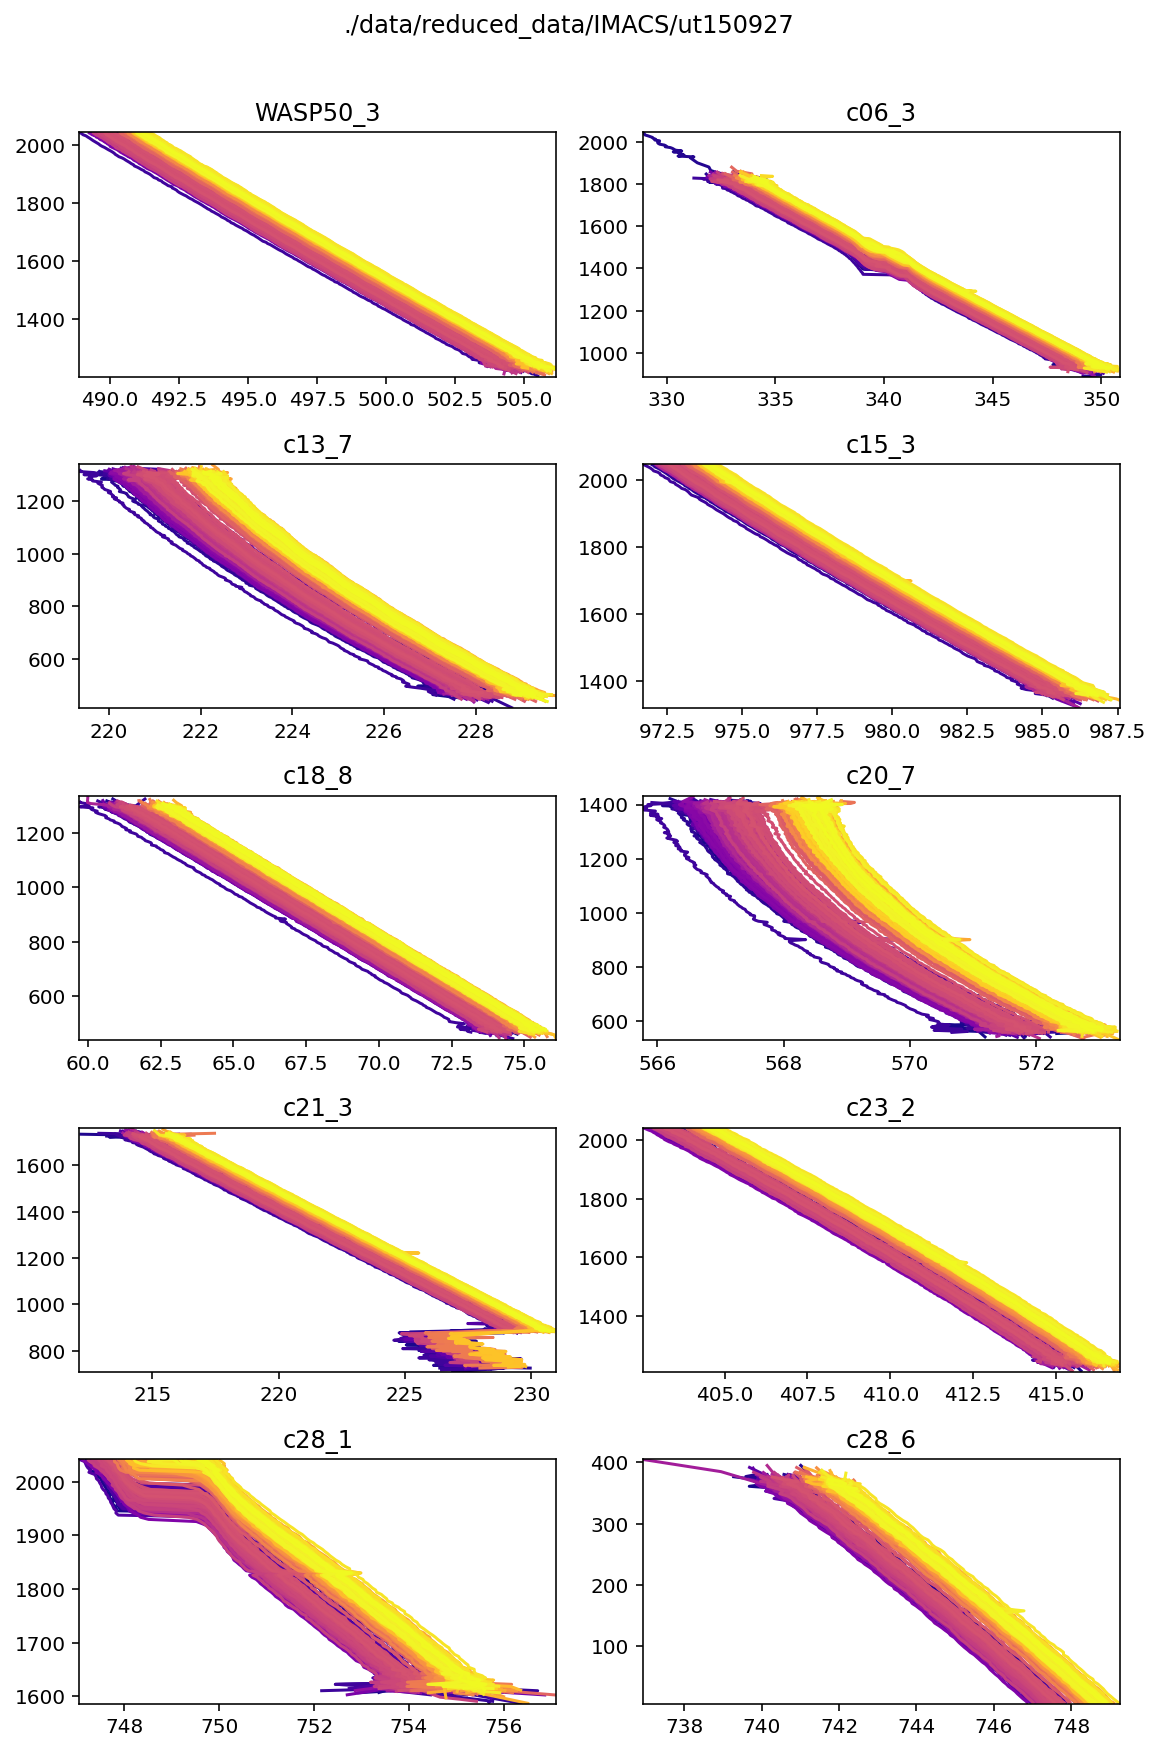

In [7]:
fig, axes, XX, YY = utils.plot_traces(
    "./data/reduced_data/IMACS/ut150927"
)
#utils.savepng('projects/HATP23/traces_ut180821')
#plt.savefig("/home/mango/Desktop/traces_transit2_imacs")

## Sub Images

In [ ]:
data = utils.fits_data("ift1258_HATP26_c2.fits")

fig, axes = plt.subplots(2, 1, figsize=FIG_WIDE, sharex=True)
ax_top, ax_bottom = axes

start = 20
end = 25
ax_top.imshow(data, aspect="auto", cmap="magma")
ax_top.grid(False)
ax_top.set_ylim(start-2, end+2)
ax_top.set_title("Sub-image (regular point 2)")

for i, row in enumerate(data[start:end, :], start=start):
    ax_bottom.plot(row, lw=1.5, label=f"{i}")
ax_bottom.legend(fontsize=11, title_fontsize=11, title="row number")
ax_bottom.set_xlabel("Pixel")
ax_bottom.set_ylabel("Counts")

fig.tight_layout()

utils.savepng("/home/mango/Desktop/sub_regular2")

In [ ]:
spec.keys()

In [ ]:
fig, ax = plt.subplots(figsize=FIG_WIDE)

data = utils.pkl_load(
    "Projects/HATP26b/data_reductions/ut190313_a15_25_noflat_LBR/LCs_bins_stevenson_combined.pkl"
)
spec = data["optimal spectra"]
wavs = spec["wavelengths"]
obj = "c01"
for (i, label) in zip([20, 197, 199], ["outlier", "regular", "regular 2"]):
    ax.plot(
        wavs,
        spec["HATP26"][i, :] / spec[obj][i, :],
        label=label,
    )
    
ax.legend()
ax.set_xlabel("Wavelength (Å)")
ax.set_ylabel("Integrated Counts")
ax.set_title(f"Opt extracted spectra (HATP26 / {obj})")

#fig.set_size_inches(FIG_WIDE)
fig.tight_layout()

#utils.savepng(f"/home/mango/Desktop/divided_opt_extr_spectra_{obj}")

## Raw Extracted Spectra

In [91]:
fig, ax = plt.subplots(figsize=FIG_WIDE)
dirpath = "/home/mango/data/data_reductions/WASP50/ut131219_a15_25_noflat"
#dirpath = './data/data_reductions/HATP23_py2/ut180620_a15_25_noflat'
fpaths = np.array(glob.glob(f"{dirpath}/*spec.fits"))
#mask = np.array(["comp5_5" not in fpath for fpath in fpaths])
#mask &= ["comp7_3" not in fpath for fpath in fpaths]
#mask &= ["comp7_8" not in fpath for fpath in fpaths]

#mask = np.array(["c05_4" not in fpath for fpath in fpaths])
#mask &= ["c05_7" not in fpath for fpath in fpaths]

#mask = np.array(["com03_6" not in fpath for fpath in fpaths])
#fpaths = fpaths[mask]
objs = {}
for i, obj_path in enumerate(fpaths):
    p, p_name, wavs, p_data = utils.plot_spec_file_objects(
        ax, obj_path, i=1,
    )
    objs[p_name] = p_data

ax.set_title(dirpath)
ax.legend(loc=2, fontsize=12)
ax.set_xlim(0, 2_000)
#ax.set_ylim(-10, 90_000)
ax.set_xlabel("pixel (dispersion direction)")
ax.set_ylabel("counts")
fig.tight_layout()
#date = Path(dirpath).parts[-1].split('_')[0]
#utils.savepng("/home/mango/Projects/HATP26b/journal/figures/spectra")

## Wavelength Calibration

Some of the lamp spectra through the target and comparison star slits are usually completely shifted off of the reference lamp spectra, so `guess_lines.py` can't be used. Instead of using this, the lines can be manually identified from [NOAO](http://iraf.noao.edu/specatlas/henear/henear.html). After getting the first target done, the rest can be bootstrapped relatively quickly since their arc spectra should be similar.

To make things a little easier, the following routine will automatically record the pixel and wavelength coordinate of each line selected from the bottom panel. To select the pixel value under the mouse, press 'X' on the keyboard. To record the corresponding wavelength value, click on the annotated value in the top reference panel. Rinse and repeat.

### Select lines

In [6]:
## Reference (NOAO), do this one first
fpath_arc_ref = "noao_flux.fits"
fpath_lines_ref = "noao_line_list.txt"

# Reference (target) arc spectra, use as ref after calibrating inital with NOAO
#dirpath_ref = "/home/mango/data/data_reductions/WASP50/ut150922_a15_25_noflat/arcs"
#fpath_arc_ref = f"{dirpath_ref}/WASP50_3_arc.fits"
#name = fpath_arc_ref.split('/')[-1].split('_')[0]
#fpath_lines_ref = f"{dirpath_ref}/{name}_guesses.csv"
#fpath_lines_ref = f"{dirpath_ref}/{name}_lines_chips.txt"

# Arc spectra to compare
dirpath = "/home/mango/Desktop/arcs"
fpath_arc = f"{dirpath}/HATP26b_2_arc.fits"
name = fpath_arc.split('/')[-1].split('_')[0]
fpath_lines = f"{dirpath}/{name}_guesses.csv"
#fpath_lines = f"{dirpath}/{name}_lines_chips.txt"

# Plot
wavs, pixels = utils.compare_arc_lines(
    fpath_arc_ref=fpath_arc_ref, 
    fpath_lines_ref=fpath_lines_ref,
    fpath_arc=fpath_arc,
    fpath_lines=fpath_lines,
    sharex=False, sharey=False,
)

### Write to file

In [103]:
df_guesses = pd.read_csv(fpath_lines, escapechar='#')
# update if lines chosen
#if len(wavs) != 0 and len(pixels) != 0:
chips = [int(fpath_arc.split('/')[-1].split('_')[1])] * len(wavs)
df_chosen = pd.DataFrame({"Wav":wavs, "Pix":pixels, "Chip":chips})

df_guesses = pd.concat([df_guesses, df_chosen])

fname = fpath_lines.split('/')[-1]
df_guesses = df_guesses.sort_values(by=["Chip", "Wav"])
display(df_guesses)
print(f"Will save to: {dirpath}/{fname}")

save = input("Continue? (y/n): ")
if save.lower() == 'y': 
    df_guesses.to_csv(f"{dirpath}/{fname}", index=False, escapechar='#')
    print(f"Saved to: {dirpath}/{fname}")
else: 
    print("not saved") 

,Wav,Pix,Chip
0,5764.4188,1697.025042,1
1,5852.4878,1714.519872,1
2,5944.8342,1732.745364,1
3,6143.0626,1771.392192,1
4,6334.4278,1808.501929,1
5,6402.2460,1821.896568,1
6,6506.5281,1841.878735,1
7,6717.0430,1882.721404,1
8,6965.4307,1930.151602,1
9,7173.9381,1970.115934,1


Will save to: /home/mango/data/data_reductions/WASP50/ut161211_a24_42_noflat/arcs/c28_guesses.csv
Continue? (y/n): y
Saved to: /home/mango/data/data_reductions/WASP50/ut161211_a24_42_noflat/arcs/c28_guesses.csv


### View wavelength solution

In [213]:
# Plot
fig, ax = plt.subplots(figsize=FIG_LARGE)

dir_lines = "/home/mango/data/data_reductions/WASP50/ut131219_a15_25_noflat/arcs"
#fpaths = glob.glob(f"{dir_lines}/*guesses*.csv")
fpaths = sorted(glob.glob(f"{dir_lines}/*lines_chips.txt"))
x_name = "Pix"
y_name = "Wav"
if ".txt" in fpaths[0]:
    sep = "\t"
else:
    sep = ","
for fpath in fpaths:
    df = pd.read_csv(fpath, escapechar="#", sep=sep)
    comp_name = fpath.split('/')[-1].split('_')[0].split("comp")[-1]
    utils.plot_pix_wav(ax, df, x_name, y_name, comp_name)

ax.legend(frameon=True, ncol=3)
ax.set_xlabel(x_name)
ax.set_ylabel(y_name)

fig.tight_layout()

utils.savefig("/home/mango/Desktop/wav_sol.png", dpi=250)

## Final spectra

In [53]:
wbins = np.loadtxt("/home/mango/data/data_reductions/WASP50/w50_ut131219_bins.dat")
np.c_[wbins, np.diff(wbins)]

array([[4810. , 5000. ,  190. ],
       [5000. , 5200. ,  200. ],
       [5200. , 5400. ,  200. ],
       [5400. , 5600. ,  200. ],
       [5600. , 5800. ,  200. ],
       [5800. , 5985.8,  185.8],
       [5985.8, 6185.8,  200. ],
       [6185. , 6420. ,  235. ],
       [6420. , 6655. ,  235. ],
       [6655. , 6855. ,  200. ],
       [6855. , 7055. ,  200. ],
       [7055. , 7255. ,  200. ],
       [7255. , 7455. ,  200. ],
       [7455. , 7655. ,  200. ],
       [7655. , 7709. ,   54. ],
       [7709. , 7909. ,  200. ],
       [7909. , 8109. ,  200. ],
       [8109. , 8269. ,  160. ],
       [8269. , 8469. ,  200. ],
       [8469. , 8669. ,  200. ],
       [8669. , 8869. ,  200. ],
       [8869. , 9069. ,  200. ],
       [9069. , 9269. ,  200. ],
       [9269. , 9469. ,  200. ],
       [9469. , 9669. ,  200. ],
       [9669. , 9819. ,  150. ]])

In [43]:
(6655 - 6185) / 2

235.0

In [50]:
6185 + 235# + 235

6420

In [46]:
dw = 200
for i, w in enumerate(np.arange(6185, 6655, 235)):
    print(f'{w:.2f}', f'{w+dw:.2f}')
    
print(i)

6185.00 6385.00
6420.00 6620.00
1


In [89]:
sns.set_palette("colorblind")
#data_dir = "data_reductions/HATP26b"
#binsize = "bins_stevenson_combined"
#date = "190313"
#N = 1
# data_dict = {
#     f"Transit 1":
#     f"/home/mango/data/data_reductions/HATP26/ut190313_a15_25_noflat/LCs_hp26_stevenson.pkl",

#     'Transit 2':
#     f'{data_dir}/ut170609_a15_25_noflat/LCs_hp23_{binsize}.pkl',

#     'Transit 3':
#     f'{data_dir}/ut180603_a15_25_noflat/LCs_hp23_{binsize}.pkl',

#     'Transit 4':
#     f'{data_dir}/ut180620_a15_25_noflat/LCs_hp23_{binsize}.pkl',

#     'Transit 5':
#     f'{data_dir}/ut180821_a15_25_noflat/LCs_hp23_{binsize}.pkl',
#}

#data_dict = {
#    "Transit 1":
#    f"{data_dir}/ut190313_a15_25_noflat_LBR/LCs_{binsize}.pkl"
#}

data_dir = "/home/mango/data/data_reductions/WASP50"
data_dict = {
    "Transit 1":{
        "fpath":f"{data_dir}/ut131219_a15_25_noflat/LCs_w50_ut131219_bins.pkl",
        "wbins":f"{data_dir}/w50_ut131219_bins.dat"
    },
    "Transit2":{
        "fpath":f"{data_dir}/ut150922_a15_25_noflat/LCs_{binsize}.pkl",
        "wbins":f"{data_dir}/w50_ut150922_bins.dat"
    },
    "Transit3":{
        "fpath":f"{data_dir}/ut150927_a15_25_noflat/LCs_{binsize}.pkl",
        "wbins":f"{data_dir}/w50_ut150927_bins.dat"
    },
    "Transit4":{
        "fpath":f"{data_dir}/ut161211_a24_42_noflat/LCs_{binsize}.pkl",
        "wbins":f"{data_dir}/w50_ut161211_bins.dat"
    },   
}

#set_theme('paper')
#paper_path = 'projects/HATP23b/paper/figures'
for transit, transit_data in data_dict.items():
    print(transit)
    data = utils.load_pickle(transit_data["fpath"])
    spec = data['spectra']
    wavs = spec["wavelengths"]
    print(wavs[[data['idx_usable_wl']]])
    
    wbins = pd.read_table(
        transit_data["wbins"],
        names=['wav_d', 'wav_u'],
        skiprows=1,
        sep='\s+',
        comment='#',
    )
    
    print(np.c_[wbins, np.diff(wbins)])
    
    fig, ax = plt.subplots(figsize=FIG_WIDE)
    c = 'darkgrey'
    for name, data in sorted(spec.items()):
        if (name != 'wavelengths'):
            p, wav, flux = utils._plot_spec_file(
                ax, data=data, wavs=wavs, label=name,
            )
        if "WASP50" in name:
            p[0].set_zorder(100)
    ax.legend(loc=1, fontsize=12)
    
    # bins
    for i, (w_d, w_u) in enumerate(zip(wbins['wav_d'], wbins['wav_u'])):
        c = 'k' if i % 2 == 0 else 'darkgrey'
        ax.axvspan(w_d, w_u, alpha=0.25, color=c, lw=0)
    
    # species lines
    species = {
        'Na I-D':5892.9, 
        'K I_avg':7682.0, 
        'Na I-8200_avg':8189.0
    }
    [ax.axvline(wav, ls='--', lw=1, color='grey') for name, wav in species.items()]
    title = transit
    ax.set_xlabel('Wavelength (Å)')
    ax.set_ylabel('Normalized flux')
    ax.set_title(title)
    ax.set_xlim(wavs[0], wavs[-1])
    #ax.set_ylim(-0.01, 1.5)

    title = title.lower().replace(' ', '_') + '_extr_spec'
    fig.set_size_inches(FIG_WIDE)
    fig.tight_layout()
    #utils.savefig(f'{paper_path}/extracted_spectra/{title}.pdf')
    #utils.savepng("/home/mango/Projects/HATP26b/journal/figures/spectra")
    #utils.savepng("/home/mango/Desktop/unnormed_spec")
    #utils.savefig(f"/home/mango/Desktop/{title}.png", dpi=250)

# objs = ["HATP26b", "c01", "c03", "c05"]
# for obj in objs:
#     spec_hp23 = np.nan_to_num(spec[obj], nan=-20_000)
#     spec_hp23.shape
#     x = spec["wavelengths"]
#     ys = [row for row in spec_hp23]

#     plot_lines2(x, ys, f"Transit {N} {obj}")

    #utils.savepng(f"/home/mango/Desktop/transit{N}_{obj}")

Transit 1
[4806.25 4807.5  4808.75 ... 9821.25 9822.5  9823.75]
[[4810.  5000.   190. ]
 [5000.  5200.   200. ]
 [5200.  5400.   200. ]
 [5400.  5600.   200. ]
 [5600.  5800.   200. ]
 [5800.  5985.8  185.8]
 [5985.8 6185.8  200. ]
 [6185.  6420.   235. ]
 [6420.  6655.   235. ]
 [6655.  6855.   200. ]
 [6855.  7055.   200. ]
 [7055.  7255.   200. ]
 [7255.  7455.   200. ]
 [7455.  7655.   200. ]
 [7655.  7709.    54. ]
 [7709.  7909.   200. ]
 [7909.  8109.   200. ]
 [8109.  8269.   160. ]
 [8269.  8469.   200. ]
 [8469.  8669.   200. ]
 [8669.  8869.   200. ]
 [8869.  9069.   200. ]
 [9069.  9269.   200. ]
 [9269.  9469.   200. ]
 [9469.  9669.   200. ]
 [9669.  9819.   150. ]]


<ipython-input-89-9992e77a39b4>:55: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  print(wavs[[data['idx_usable_wl']]])


Transit2
[6997.5  6998.75 7000.   7001.25 7002.5  7003.75 7005.   7006.25 7007.5
 7008.75 7010.   7011.25 7012.5  7013.75 7015.   7016.25 7017.5  7018.75
 7020.   7021.25 7022.5  7023.75 7025.   7026.25 7027.5  7028.75 7030.
 7031.25 7032.5  7033.75 7035.   7036.25 7037.5  7038.75 7040.   7041.25
 7042.5  7043.75 7045.   7046.25 7047.5  7048.75 7050.   7051.25 7052.5
 7053.75 7055.   7056.25 7057.5  7058.75 7060.   7061.25 7062.5  7063.75
 7065.   7066.25 7067.5  7068.75 7070.   7071.25 7072.5  7073.75 7075.
 7076.25 7077.5  7078.75 7080.   7081.25 7082.5  7083.75 7085.   7086.25
 7087.5  7088.75 7090.   7091.25 7092.5  7093.75 7095.   7096.25 7097.5
 7098.75 7100.   7101.25 7102.5  7103.75 7105.   7106.25 7107.5  7108.75
 7110.   7111.25 7112.5  7113.75 7115.   7116.25 7117.5  7118.75 7120.
 7121.25 7122.5  7123.75 7125.   7126.25 7127.5  7128.75 7130.   7131.25
 7132.5  7133.75 7135.   7136.25 7137.5  7138.75 7140.   7141.25 7142.5
 7143.75 7145.   7146.25 7147.5  7148.75 7150.   715

<ipython-input-89-9992e77a39b4>:55: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  print(wavs[[data['idx_usable_wl']]])


Transit3
[5663.75 5665.   5666.25 ... 7426.25 7427.5  7428.75]
[[5600.  5800.   200. ]
 [5800.  5985.8  185.8]
 [5985.8 6185.8  200. ]
 [6185.  6420.   235. ]
 [6420.  6655.   235. ]
 [6655.  6855.   200. ]
 [6855.  7055.   200. ]
 [7055.  7255.   200. ]
 [7255.  7455.   200. ]
 [7455.  7655.   200. ]
 [7655.  7709.    54. ]
 [7709.  7909.   200. ]
 [7909.  8109.   200. ]
 [8109.  8269.   160. ]
 [8269.  8469.   200. ]
 [8469.  8669.   200. ]
 [8669.  8869.   200. ]
 [8869.  9069.   200. ]
 [9069.  9269.   200. ]
 [9269.  9469.   200. ]
 [9469.  9669.   200. ]]


<ipython-input-89-9992e77a39b4>:55: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  print(wavs[[data['idx_usable_wl']]])


Transit4
[5626.25 5627.5  5628.75 ... 8688.75 8690.   8691.25]
[[5600.  5800.   200. ]
 [5800.  5985.8  185.8]
 [5985.8 6185.8  200. ]
 [6185.  6420.   235. ]
 [6420.  6655.   235. ]
 [6655.  6855.   200. ]
 [6855.  7055.   200. ]
 [7055.  7255.   200. ]
 [7255.  7455.   200. ]
 [7455.  7655.   200. ]
 [7655.  7709.    54. ]
 [7709.  7909.   200. ]
 [7909.  8109.   200. ]
 [8109.  8269.   160. ]
 [8269.  8469.   200. ]
 [8469.  8669.   200. ]
 [8669.  8869.   200. ]
 [8869.  9069.   200. ]
 [9069.  9269.   200. ]
 [9269.  9469.   200. ]]


<ipython-input-89-9992e77a39b4>:55: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  print(wavs[[data['idx_usable_wl']]])


In [103]:
utils.load_pickle(fpath)["cNames"]

['c06', 'c13', 'c15', 'c18', 'c20', 'c21', 'c23', 'c28']

In [223]:
fig, ax = plt.subplots()

p1 = ax.plot([1, 2, 3], label="p1")

p2 = ax.plot([3, 2, 1], label="p2")

p1[0].set_zorder(100)

ax.legend()

In [7]:
def plot_lines2(x, ys, title):
    # We need to set the plot limits, they will not autoscale
    fig, ax = plt.subplots(figsize=FIG_WIDE)
    ax.set_xlim(np.min(x), np.max(x))
    ax.set_ylim(np.min(ys), np.max(ys))

    # colors is sequence of rgba tuples
    # linestyle is a string or dash tuple. Legal string values are
    #          solid|dashed|dashdot|dotted.  The dash tuple is (offset, onoffseq)
    #          where onoffseq is an even length tuple of on and off ink in points.
    #          If linestyle is omitted, 'solid' is used
    # See :class:`matplotlib.collections.LineCollection` for more information

    # Make a sequence of x,y pairs
    line_segments = LineCollection([np.column_stack([x, y]) for y in ys],
                                   linestyles='solid')
    line_segments.set_array(np.arange(len(ys)))
    ax.add_collection(line_segments)
    axcb = fig.colorbar(line_segments)
    axcb.set_label('Index #')
    plt.sci(line_segments)  # This allows interactive changing of the colormap.
    plt.viridis()
    ax.set_title(title)
    ax.set_xlabel("Wavelength")
    ax.set_ylabel("Counts")
    fig.tight_layout()

In [ ]:
spec_hp23 = np.nan_to_num(spec["HATP23b"], nan=-20_000)
spec_hp23.shape
x = spec["wavelengths"]
ys = [row for row in spec_hp23]

plot_lines2(x, ys, "Transit 1")

utils.savepng("/home/mango/Desktop/transit1")

In [ ]:
data_dict = {
    'Transit 2':
    f'{data_dir}/ut170609_a15_25_noflat/LCs_hp23_{binsize}.pkl',

    'Transit 3':
    f'{data_dir}/ut180603_a15_25_noflat/LCs_hp23_{binsize}.pkl',
}

fig, axes = plt.subplots(2, 1, figsize=FIG_LARGE)

objs = ["HATP23b", "comp4", 'comp5']
colors = ["C5", "C0", "C1"]
for ax, (transit_name, transit_path) in zip(axes.flat, data_dict.items()):
    data = utils.pkl_load(transit_path)
    time = Time(data["t"], format="jd")# - 2450000
    wavs = data["optimal spectra"]["wavelengths"]
    wav_low_idx = np.where(wavs == 5000)[0][0]
    wav_high_idx = np.where(wavs == 9000)[0][0]
    wavs_int = wavs[wav_low_idx:wav_high_idx+1]
    for obj, c in zip(objs, colors):
        f = data["optimal spectra"][obj][:,wav_low_idx:wav_high_idx+1].sum(axis=1)
        ax.plot_date(time.plot_date, f/np.max(f), '.', label=obj, color=c)

        ax.legend(ncol=3, loc=4)
        ax.set_xlabel("Wavelength (Å)")
        ax.set_ylabel("$F / F_\mathrm{max}$")

fig.tight_layout()

In [ ]:
pd.options.display.float_format = '{:.2f}'.format
fpath = "./Projects/HATP26b/data_reductions/bins_wakeford.txt"
wbins = pd.read_table(fpath, sep='\s+', comment='#')
wbins

In [ ]:
tspec = pd.DataFrame()
tspec['wav_d'] = ((wbins["wav_cen"] - wbins["delta_wav"])/2.0) * 1e4
tspec['wav_u'] = ((wbins["wav_cen"] + wbins["delta_wav"])/2.0) * 1e4
tspec["diff"] = tspec["wav_u"] - tspec["wav_d"]
tspec["wav_cen"] = wbins["wav_cen"] * 1e4
tspec["depth"] =  wbins["rprs"]**2 * 1e6
tspec["depth_unc"] = np.sqrt(4.0*wbins["rprs"]**2 * wbins["rprs_unc"]**2) * 1e6

tspec.to_csv("./Projects/HATP26b/data_detrending/tspec_wakeford.txt",
            index=False)

tspec

In [ ]:
tspec = pd.DataFrame()
tspec['wav_d'] = wbins["wav_d"] * 1e4
tspec["wav_u"] = wbins["wav_u"] * 1e4
tspec["diff"] = tspec["wav_u"] - tspec["wav_d"]
tspec["wav_cen"] = (tspec["wav_u"] + tspec["wav_d"]) / 2.0
tspec["depth"] =  wbins["depth_percent"] * 1e4
tspec["depth_unc"] = wbins["depth_unc_percent"] * 1e4

tspec.to_csv("./Projects/HATP26b/data_detrending/tspec_stevenson.txt",
            index=False)

tspec

In [ ]:
fig, ax = plt.subplots(figsize=(11, 5))
for name, data in sorted(spec.items()):
    if name != 'wavelengths':
        p, _ = utils._plot_spec_file(ax, data=data, wavs=wavs, label=name)
        
ax.set_xlim(wavs[0], wavs[-1])
ax.set_ylim(-0.01, 1.15)
ax.legend(fontsize=12)
fig.tight_layout()

## Light Curves

### WLC

In [72]:
data_dict = {
    "Transit 1":
    {
        "fpath":f"/home/mango/data/data_reductions/WASP50/ut150927_a15_25_noflat/LCs_w50_ut150927_bins.pkl",
    }
}

for transit_name, transit_data in data_dict.items():
    fpath = transit_data["fpath"]
    data = utils.load_pickle(fpath)

    fig, ax = plt.subplots(figsize=FIG_WIDE)

    # Raw fluxes
    p, _ = utils.plot_fluxes(
        ax,data,
        use_time=True,
        normalize=False,
        t0 = 0 #2458556.7500,
    )
    title = transit_name
    fig.suptitle(title)
    fig.tight_layout()
    p.set_xlabel("$t - t_0$ (hours)")
    p.set_ylabel("Normalized flux")
    
    fig, ax = plt.subplots(figsize=(4, 11))
    offs = 0
    for lc_t, lc_c in zip(data["oLCw"].T, data["cLCw"][:, 1, :].T):
        f = lc_t / lc_c
        ax.plot((f / np.median(f)) + offs, '.')
        #ax.plot(lc_c + offs)
        offs += 0.03

    #utils.savepng(f"/home/mango/Desktop/raw_LCs.png")

    #pd.DataFrame(f_data).to_csv(f"/Users/mango/Desktop/fluxes_{title}.csv", index=False)

In [67]:
data.keys()

dict_keys(['spectra', 'optimal spectra', 'Z', 'g', 'rot', 'fo', 't', 'ha', 'telev', 'theta', 'derg', 'drot', 'etimes', 'deltas', 'wbins', 'cNames', 'oLC', 'cLC', 'idx_usable_wl', 'oLCw', 'cLCw', 'traces', 'apertures', 'sky', 'fwhm'])

In [93]:
data["cLCw"][:, 3, 1]

array([1019650.44351433, 1012166.15832502, 1019269.55386362,
       1023320.31746776, 1020215.87650644, 1015923.09775631,
       1009641.64400552,  925483.11966374,  988323.52208797,
       1020853.9621004 , 1011230.08259096,  991159.38607536,
       1014912.03380143, 1034489.94516974, 1016436.65745033,
       1025233.02935917, 1024369.20077299, 1021881.71350998,
       1011030.45000661, 1025391.04125948, 1020778.66856871,
       1021975.84110735, 1021445.69708392, 1024791.56593712,
       1023854.81222973, 1029631.40454284, 1025490.71385451,
       1019857.00400582, 1003637.53128912, 1021013.39708282,
       1018005.27130563, 1006914.58748021, 1009730.96986615,
       1019938.85085389, 1010472.44530569, 1010008.95718375,
       1009925.17780282, 1021562.56405976, 1032143.74298439,
       1021426.01217501, 1019838.19891106, 1028496.67736954,
       1027595.75079383, 1025728.25827894, 1027637.97506095,
       1033667.67701926, 1025884.0002912 , 1020857.8217289 ,
       1032220.47437154,

In [17]:
data["wbins"][0]

[5300.0, 5550.0]

In [15]:
data["cLCw"][:, 3, 0]

array([2379042.13022983, 2403789.06015893, 2407239.96218858,
       2407098.23073442, 2092021.94311923, 2091536.23745845,
       2099244.97805733, 2105449.21008931, 2112896.44383283,
       2103339.38820363, 2117120.8140347 , 2107976.15008785,
       2107074.4808769 , 2107402.1511896 , 2096915.32231774,
       2104529.44434889, 2102985.02649635, 2109747.42635007,
       2106780.11247642, 2106409.86690986, 2104866.09078724,
       2125766.4079553 , 2114992.44390685, 2117267.55229477,
       2112766.83185517, 2113168.5003915 , 2115752.37877319,
       2113366.34783076, 2110212.05848903, 2122198.46410998,
       2125301.13169185, 2116888.84507131, 2107542.73002644,
       2116453.24045915, 2111026.23287263, 2119852.21322852,
       2127613.78599722, 2113659.31578768, 2120821.88998416,
       2132442.15584176, 2120999.80525211, 2112976.24406719,
       2114009.07496664, 2120358.24775083, 2126088.87944872,
       2121362.34443998, 2128200.11982442, 2122968.1954494 ,
       2119074.89493778,

In [16]:
fig, ax = plt.subplots(figsize=(4, 11))
offs = 0
for lc_t, lc_c in zip(data["oLCw"].T, data["cLCw"][:, 1, :].T):
    f = lc_t / lc_c
    ax.plot((f / np.median(f)) + offs, '.')
    #ax.plot(lc_c + offs)
    offs += 0.03

In [ ]:
pd.DataFrame(f_data)

### WLC Divided

In [3]:
#set_theme("paper")
#sns.set_context('paper')
#sns.set_palette("colorblind")
data_dir = "data/reduced_data/IMACS/nofixpix/ut131219/LCs_w50_bins_ut131219.pkl"
LCs_pickle = "LCs_w43_25nm.pkl"
# data_dict = {
#     "Transit 1":
#     {
#         "path":f"{data_dir}/ut190313_a15_25_noflat/{LCs_pickle}",
#         "bad_idxs":"[4,5,11,12]",
#         "t0":2455304.65218,
#     }
# }
data_dict = {
    "Transit 1":
    {
        "path":f"{data_dir}/ut131219/LCs_w50_bins_ut131219.pkl",
        "bad_idxs": "[81, 172, 175, 204]",
        "t0":Time("2013-12-19 03:22").jd,
    },
#     "Transit 1 (LBR)":
#     {
#         "path":f"{data_dir}/ut131219_a15_25_noflat_LBR/{LCs_pickle}",
#         "bad_idxs": "[5, 26, 43, 48, 69, 81, 86, 115, 131, 141, 145, 171, 178, 179, 181, 191, 197]",
#         "t0":Time("2013-12-19 03:22").jd,
#     },
    "Transit 2":
    {
        "path":f"{data_dir}/ut150922_a15_25_noflat/{LCs_pickle}",
        "bad_idxs": "[2, 31, 39, 92, 103, 104, 119, 125, 143, 158, 159, 339:362]",
        "t0":Time("2015-09-23 08:46").jd,
    },
    "Transit 3":
    {
        "path":f"{data_dir}/ut150927_a15_25_noflat/{LCs_pickle}",
        "bad_idxs": "[7, 8, 11, 31, 33, 89, 136, 239, 240, 322]",
        "t0":Time("2015-09-27 06:37").jd,
    },
     "Transit 3 (LBR)":
    {
        "path":f"{data_dir}/ut150927_a15_25_noflat_LBR/{LCs_pickle}",
        "bad_idxs": "[7, 11, 31, 33, 124, 136, 299, 240, 321, 322, 343]",
        "t0":Time("2015-09-27 06:37").jd,
    },
     "Transit 4":
    {
        "path":f"{data_dir}/ut161211_a24_42_noflat/{LCs_pickle}",
        "bad_idxs": "[3, 17, 18, 21, 33, 36, 39, 40:45, 48, 52, 55, 56]",
        "t0":Time("2016-12-12 03:03").jd,
    },
      "Transit 4 (LBR)":
    {
        "path":f"{data_dir}/ut161211_a24_42_noflat_LBR/{LCs_pickle}",
        "bad_idxs": "[8, 12, 13, 15, 17, 18, 21:23, 29, 30, 32, 36, 39, 40:45, 48, 49, 51, 52, 55:58, 61, 103, 137, 139, 148, 151, 165, 177, 180, 220, 232:234, 254, 260:263, 265, 266, 271, 275, 276, 279, 286, 288, 301:303, 320, 321, 325]",
        "t0":Time("2016-12-12 03:03").jd,
    },
}
# data_dict = {
#     'Transit 1':
#         {
#             'path':f'{data_dir}/ut160621_a15_20_noflat/{LCs_pickle}_160621.pkl',
#             'bad_idxs':'[239, 240, 241, 256, 276, 278, 283, 284, 288:299]',
#             't0':2457561.84167,
#         },
    
#     'Transit 2':
#         {
#             'path':f'{data_dir}/ut170609_a15_25_noflat/{LCs_pickle}.pkl',
#             'bad_idxs':'[10]',
#             't0':2457914.79167,
#         },
    
#     'Transit 3':
#         {
#             'path':f'{data_dir}/ut180603_a15_25_noflat/{LCs_pickle}.pkl',
#             'bad_idxs':'[0:17]',
#             't0':2458273.80556,
#         },
    
#     'Transit 4':
#         {
#             'path':f'{data_dir}/ut180620_a15_25_noflat/{LCs_pickle}.pkl',
#             'bad_idxs':'[93, 94, 149, 157:171]',
#             't0':2458290.78472,
#         },
#     'Transit 5':
#         {
#             'path':f'{data_dir}/ut180821_a15_25_noflat/{LCs_pickle}.pkl',
#             #'bad_idxs':'[4:6, 51, 53, 54, 56:59, 64, 66, 68, 69, 72, 77:80, 87:94, 96:98, 101, 108:119, 120, 129:131, 133, 174:181]',
#             'bad_idxs':'[4:6, 51, 53, 54, 56:59, 64, 66, 68, 69, 72, 77:80, 87:94, 96:98, 101, 129:131, 133, 174:181]',
#             #'bad_idxs':'[108:120]',
#             't0':2458352.64028,
#         },
    
# }

# comps = ['c06', 'c13', 'c15', 'c18', 'c20', 'c21', 'c23', 'c28']
# ncomps = len(comps)
# nrows = 2
# ncols = int(ncomps / nrows)
# fig, axes = plt.subplots(
#     nrows, ncols, 
#     sharex=True, sharey=True,
#     figsize=FIG_LARGE,
# )
#axes = axes.flatten()
#if axes.ndim == 1: axes = axes.reshape(1, axes.size) 
for i, (transit_name, transit_info) in enumerate(data_dict.items()):
    fpath = transit_info['path']
    t0 = transit_info['t0']
    data = utils.load_pickle(fpath)
    print(fpath)
    print(len(data['t']))
    print(data['cNames'])
    comps = data["cNames"]
    ncomps = len(comps)
    nrows = 2
    ncols = int(ncomps / nrows)
    fig, axes = plt.subplots(
       nrows, ncols, 
       sharex=True, sharey=True,
       figsize=FIG_LARGE,
    )
    
    for ax, comp in zip(axes.flat, comps):
        p = utils.plot_divided_wlcs(
            ax,
            data,
            t0=t0,
            ferr=0.001,
            comps_to_use=[comp],
            bad_idxs_user = transit_info['bad_idxs'],
            div_kwargs={'fmt':'.', 'lw':0.5, 'mew':0.0, 'ms':3, 'c':f"C{i}"},
            #bad_div_kwargs={'fmt':'.', 'lw':1.0, 'mew':0.0, 'ms':6, 'c':f"C{i+1}"},
        )
        #ax.set_title(comp)
        ax.annotate(
            rf"{transit_name}/{comp}",
            xy=(0.05, 0.05),
            xycoords='axes fraction',
            fontsize=12, color=f"C{i}",
            weight='bold',
        )
        #ax.set_xlim(-3, 3)
        #ax.xaxis.set_ticks([-3, -2, -1, 0, 1, 2, 3])
        ax.set_ylim(0.95, 1.04)
        ax.yaxis.set_ticks([0.96, 0.98, 1.00, 1.02, 1.04])
        #fig.set_size_inches(12, 3)
        #i += 1

    fig.suptitle(transit_name)
    fig.text(0.54, -0.02, 'Time from estimated mid-transit (hours)', ha='center')
    fig.text(-0.01, 0.5, 'Normalizd flux', va='center', rotation='vertical')
    fig.tight_layout()
    
    print()
    
    title = transit_name.lower().replace(' ', '_') + '_extr_wlcs'
    utils.savefig(f"/home/mango/Desktop/{title}.png", dpi=250)

    
    # Custom legend
#handles, labels = [], []
#for transit_name in list(data_dict.keys()):
#    dummy = plt.errorbar([], [], yerr=0.1, fmt='o', ms=5, elinewidth=2, label=transit_name)
#    handles.append(dummy)
#    labels.append(transit_name)
#fig.legend(handles, labels, ncol=5, bbox_to_anchor=(0.54, 1.1), loc='upper center')#, ncol=len(data_dict)+1) 
#axes[0, 0].set_title('comp4')
#axes[0, 1].set_title('comp5')

# fig.text(0.54, -0.02, 'Time from estimated mid-transit (hours)', ha='center')
# fig.text(-0.01, 0.5, 'Normalizd flux', va='center', rotation='vertical')
# #axes[0].set_ylabel('Normalized flux')
# fig.tight_layout()
#fig.set_size_inches(12, 3)
#utils.savepng("/home/mango/Projects/HATP26b/journal/figures/wlc")

    #plt.savefig('/Users/mango/Desktop/wlc_py2_py3.png', dpi=250, bbox_inches='tight')

NameError: name 'Time' is not defined

In [182]:
baddies = set([41, 44, 220, 260, 275]).union(
    set([12, 13, 17, 40, 41, 42, 43, 44, 45, 51, 52])
).union(
    set([266, 276, 288, 321])
).union(
    set([8, 21, 22, 23, 29, 30, 39, 40, 41, 42, 43, 44, 51, 55, 56, 57, 58, 61])
).union(
    set([15, 18, 29, 32, 36, 39, 40, 41, 42, 43, 44, 45, 48, 49])
).union(
    set([232, 254, 260, 261, 262, 263, 271, 279, 286, 301, 302, 320, 325])
).union(
    set([233, 234, 265, 303])
)

print(sorted(baddies))

[8, 12, 13, 15, 17, 18, 21, 22, 23, 29, 30, 32, 36, 39, 40, 41, 42, 43, 44, 45, 48, 49, 51, 52, 55, 56, 57, 58, 61, 220, 232, 233, 234, 254, 260, 261, 262, 263, 265, 266, 271, 275, 276, 279, 286, 288, 301, 302, 303, 320, 321, 325]


In [29]:
fig, ax = plt.subplots()

p = ax.plot([1,2,3], c = "C2")

ax.plot([3, 2, 1], c=p[0].get_color())

In [67]:
int(p[0].get_color()[1])

2

In [69]:
np.array(sns.color_palette()[2]) * 0.5

array([0.01568627, 0.48431373, 0.49803922])

In [251]:
targ_flux = data["oLC"]
targ_flux = targ_flux / np.median(targ_flux)

In [252]:
comp_flux = data["cLC"][:, 0]
comp_flux = comp_flux / np.median(comp_flux)

In [254]:
plt.plot(targ_flux / comp_flux, '.')

In [ ]:
print(sorted(set([6, 51, 52, 55, 59, 64, 65, 66, 67, 68, 69, 72, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 100, 101, 108, 111, 112, 113, 120, 129, 130, 131, 132, 133, 178, 179, 180]).union(set([55, 56, 59, 68, 88, 89, 90, 91, 97, 120, 178]))))

In [ ]:
fig, ax = plt.subplots(figsize=FIG_WIDE, sharex=True, sharey=True)

comps_to_use =  ["comp4", "comp5"] #data["cNames"]
p, i_used, t, f_div_sum, i_not_used, i_all = utils.plot_sum_divided_wlcs(
    ax,
    data,
    comps_to_use=comps_to_use,
    bad_idxs_user = "[53:59, 64, 65, 68, 78:80, 88:91, 97, 109, 110:120, 173:181]",
    div_sum_kwargs={"fmt":'.', "mew":0, "alpha":0.5, "lw":0.5},
)
p.legend(ncol=3, loc="upper center", frameon=True)

fig.tight_layout()

In [ ]:
# Preview divided LC
fig, ax = plt.subplots(figsize=FIG_WIDE)

ax.errorbar(i_used, f_div_sum[i_used], yerr=0.001, fmt='.', lw=0.5)

fig.tight_layout()

In [ ]:
ferr = 0.001 * np.ones_like(i_used)
instrument = ["MAGELLAN"] * len(i_used)
df_juliet = pd.DataFrame(
    zip(t[i_used] - 2457000, f_div_sum[i_used].flatten(), ferr, instrument),
)
df_juliet

In [ ]:
p = pathlib.Path("juliet/hatp23_test/")
p.mkdir(parents=True, exist_ok=True)
df_juliet.to_csv(
    f"{p}/lc.dat",
    float_format="%.10f",
    sep=' ',
    header=False,
    index=False,
)

with open(p / "used_comps_and_bad_idxs.txt", "w") as f:
    f.writelines([f"{comps_to_use}\n", f"{i_not_used}"])
    
print("Saved")

### Binned

In [90]:
data = utils.load_pickle(
    "/home/mango/data/data_reductions/WASP50/ut150922_a15_25_noflat/LCs_w50_ut150922_bins.pkl"
)
print(data["cNames"])

# Identify bad time idxs
wbins_range = range(0, 38)
bins = np.array(data["wbins"])#[wbins_range]
time = data['t']

# bad_idxs = "[81, 172, 175, 204]"
# comps_to_use_idxs = [1, 2, 3, 4, 5, 6]

bad_idxs = "[2, 31, 39, 92, 103, 104, 119, 125, 143, 158, 159, 339:362]"
comps_to_use_idxs = [2, 3]

# bad_idxs = "[7, 8, 11, 31, 33, 89, 136, 239, 240, 322]"
# comps_to_use_idxs = [1, 2, 3, 4, 5, 6]

# bad_idxs = "[3, 17, 18, 21, 33, 36, 39, 40:45, 48, 52, 55, 56]"
# comps_to_use_idxs = [0, 1, 4]

bad_idxs = utils._bad_idxs(bad_idxs)
if bad_idxs is not None:
    idxs_used = np.delete(range(len(time)), bad_idxs)
else:
    idxs_used = range(len(time))
    
# Get target flux
flux_target = np.c_[data["oLCw"]]

# Select comps
cNames = data["cNames"]

fig, axes = plt.subplots(1, 2, figsize=(8, 11), sharex=True, sharey=True)
ax_left, ax_right = axes

########
# Left
########
flux_comps_used = np.c_[data["cLCw"][:, comps_to_use_idxs, :]]
flux_comps_used_sum = np.c_[np.sum(flux_comps_used, axis=1)]

# Divide target flux by sum of chosen comp sum
flux_div_sum = flux_target / flux_comps_used_sum
flux_div_sum /= np.median(flux_div_sum, axis=0)
fluxes = flux_div_sum[idxs_used, :]#[:, wbins_range]
N_bins = fluxes.shape[1]

offs = 0.05
p_left = utils.plot_binned(
        ax_left,
        idxs_used,
        fluxes,
        utc=False,
        bins=bins, 
        offset=offs,
        colors=np.array(sns.color_palette("Spectral_r", N_bins)),
        plot_kwargs={"marker":'.', "mew":0, "lw":0}
    )
#p_left.set_title("HAT-P-26 / c01")

########
# Right
########
p_right = utils.plot_binned(
        ax_right,
        idxs_used,
        np.ones_like(fluxes),
        utc=False,
        bins=bins, 
        offset=offs,
        colors=np.array(sns.color_palette("Spectral_r", N_bins)),
        annotate=True,
        annotate_kwargs={"fontsize":8, "ha":"center"},
        annotate_rms_kwargs = {
            "fontsize":8, 
            "horizontalalignment":'left',
            "path_effects":[PathEffects.withStroke(linewidth=1, foreground="k")],
        }
    )
p_right.set_title("Bins")

trans = transforms.blended_transform_factory(
            p_right.transAxes, p_right.transData
        )

ax_left.set_ylabel("Normalized flux + offset")
fig.text(0.5, 0, 'Index', ha='left')

fig.tight_layout()

['c06', 'c13', 'c15', 'c18', 'c20', 'c21', 'c23', 'c28']


<ipython-input-90-38294488a2a8>:45: RuntimeWarning: divide by zero encountered in true_divide
  flux_div_sum = flux_target / flux_comps_used_sum


In [77]:
########
# Middle
########
#comps_to_use = ["c03"] #cNames
#comps_to_use_idxs = [cNames.index(cName) for cName in comps_to_use]
flux_comps_used = np.c_[data["cLCw"][:, comps_to_use_idxs, :]]
flux_comps_used_sum = np.c_[np.sum(flux_comps_used, axis=1)]

# Divide target flux by sum of chosen comp sum
flux_div_sum = flux_target / flux_comps_used_sum
flux_div_sum /= np.median(flux_div_sum, axis=0)
fluxes = flux_div_sum[idxs_used, :]#[:, wbins_range]
N_bins = fluxes.shape[1]

offs = 0.01
p_middle = utils.plot_binned(
        ax_middle,
        idxs_used,
        fluxes,
        utc=False,
        bins=bins, 
        offset=offs,
        colors=np.array(sns.color_palette("Spectral_r", N_bins)),
        plot_kwargs={"marker":'.', "mew":0, "lw":0}
    )
#p_middle.set_title("HAT-P-26 / c03")

#plt.savefig("/Users/mango/Desktop/binned_lc.png", dpi=250, bbox_inches="tight")
#utils.savepng("/home/mango/Desktop/bad_region")
#utils.savepng("/home/mango/Projects/HATP26b/journal/figures/raw_blcs"

In [ ]:
        ax_left,
        idxs_used,
        fluxes,
        utc=False,
        bins=bins, 
        offset=offs,
        colors=np.array(sns.color_palette("Spectral_r", N_bins)),
        plot_kwargs={"marker":'.', "mew":0, "lw":0}

In [ ]:
        ax_left,
        idxs_used,
        fluxes,
        utc=False,
        bins=bins, 

In [ ]:
data = utils.pkl_load(
    "/home/mango/ACCESS_notebook/Projects/HATP26b/data_reductions/ut190313_a15_25_noflat_LBR/LCs_bins_stevenson_combined.pkl"
)

# Identify bad time idxs
time = data['t']
bad_idxs = '[4,5,11,12]' #'[4:6, 51, 53, 54, 56:59, 64, 66, 68, 69, 72, 77:80, 87:94, 96:98, 101, 108:119, 120, 129:131, 133, 174:181]'
bad_idxs = utils._bad_idxs(bad_idxs)
if bad_idxs is not None:
    idxs_used = np.delete(range(len(time)), bad_idxs)
else:
    idxs_used = range(len(time))
    
# Get target flux
flux_target = np.c_[data["oLCw"]]

# Select comps
cNames = data["cNames"]

fig, axes = plt.subplots(1, 3, figsize=(8, 11), sharex=True, sharey=True)
ax_left, ax_middle, ax_right = axes

wbins_idxs = slice(0, 10)
########
# Left
########
comps_to_use = ["c01"] #cNames
comps_to_use_idxs = [cNames.index(cName) for cName in comps_to_use]
flux_comps_used = np.c_[data["cLCw"][:, comps_to_use_idxs, :]]
flux_comps_used_sum = np.c_[np.sum(flux_comps_used, axis=1)]

# Divide target flux by sum of chosen comp sum
flux_div_sum = flux_target / flux_comps_used_sum
flux_div_sum /= np.median(flux_div_sum, axis=0)
fluxes = flux_div_sum[idxs_used, :]
N_bins = fluxes.shape[1]

offs = 0.008
p_left = utils.plot_binned(
        ax_left,
        idxs_used[wbins_idxs],
        fluxes[wbins_idxs],
        utc=False,
        bins=np.array(data["wbins"]), 
        offset=offs,
        colors=np.array(sns.color_palette("Spectral_r", N_bins)),
        plot_kwargs={"marker":'.', "mew":0, "lw":0}
    )
p_left.set_title("c01")

########
# Middle
########
comps_to_use = ["c03"] #cNames
comps_to_use_idxs = [cNames.index(cName) for cName in comps_to_use]
flux_comps_used = np.c_[data["cLCw"][:, comps_to_use_idxs, :]]
flux_comps_used_sum = np.c_[np.sum(flux_comps_used, axis=1)]

# Divide target flux by sum of chosen comp sum
flux_div_sum = flux_target / flux_comps_used_sum
flux_div_sum /= np.median(flux_div_sum, axis=0)
fluxes = flux_div_sum[idxs_used, :][wbins_idxs]
N_bins = fluxes.shape[1][wbins_idxs]

offs = 0.008
p_middle = utils.plot_binned(
        ax_middle,
        idxs_used,
        fluxes,
        utc=False,
        bins=np.array(data["wbins"]), 
        offset=offs,
        colors=np.array(sns.color_palette("Spectral_r", N_bins)),
        plot_kwargs={"marker":'.', "mew":0, "lw":0}
    )
p_middle.set_title("c03")

########
# Right
########
p_right = utils.plot_binned(
        ax_right,
        idxs_used,
        np.ones_like(fluxes),
        utc=False,
        bins=np.array(data["wbins"]), 
        offset=offs,
        colors=np.array(sns.color_palette("Spectral_r", N_bins)),
        annotate=True,
        annotate_kwargs={"fontsize":8, "ha":"center"},
        annotate_rms_kwargs = {
            "fontsize":8, 
            "horizontalalignment":'left',
            "path_effects":[PathEffects.withStroke(linewidth=1, foreground="k")],
        }
    )
p_right.set_title("Bins")

trans = transforms.blended_transform_factory(
            p_right.transAxes, p_right.transData
        )

ax_left.set_ylabel("Normalized flux + offset")
fig.text(0.5, 0, 'Index', ha='left')

fig.tight_layout()

#plt.savefig("/Users/mango/Desktop/binned_lc.png", dpi=250, bbox_inches="tight")

#utils.savepng("/home/mango/Projects/HATP26b/journal/figures/raw_blcs"

In [ ]:
offs

In [ ]:
offs = 0
for BMA_val in BMA_vals:
    p_right.annotate(
        ', '.join(f"{v:.3f}" for v in BMA_val),
        xy=(0.25, 1.002*(1 + offs)),
        xycoords=trans,
        fontsize=8,
        color='y',
    )
    offs += 0.008

In [ ]:
data['idx_usable_wl']

In [ ]:
data['optimal spectra']['wavelengths']#[data['idx_usable_wl']]

In [ ]:
data['idx_usable_wl'].shape

In [ ]:
# Save to file
data = np.c_[time[idxs_used], fluxes]
p = pathlib.Path("xo/WASP43/ut180603/binned_free_rho_star")
p.mkdir(parents=True, exist_ok=True)
np.save(f"{p}/lc_w.npy", data)

In [ ]:
np.load(p / "lc_w.npy").shape

# Detrending

## PCA

In [ ]:
data = np.genfromtxt(
    "./Projects/HATP26b/data_detrending/out_wa/HATP26/hp26_190313_wa/white-light/comps.dat",
    unpack=True,
)
for i in range(len(data)):
    x = (data[i] - np.mean(data[i])) / np.sqrt(np.var(data[i]))
    if i == 0:
        Xc = x
    else:
        Xc = np.vstack((Xc, x))

Xc[0].shape

data = np.genfromtxt(
    "./Projects/HATP26b/data_detrending/out_wa/HATP26/hp26_190313_wa/eparams.dat",
    unpack=True,
)

data.shape

post = utils.pkl_load(
    "./Projects/HATP26b/data_detrending/out_st/HATP26/hp26_190313_st/white-light/PCA_2/posteriors_trend_george.pkl"
)
post["posterior_samples"].keys()

BMA = utils.pkl_load(
    "./Projects/HATP26b/data_detrending/out_st/HATP26/hp26_190313_st/white-light/BMA_posteriors.pkl"
)
BMA.keys()

In [ ]:
post = utils.pkl_load(
    "./Projects/HATP26b/data_detrending/out_st/HATP26/hp26_190313_st/white-light/PCA_2/posteriors_trend_george.pkl"
)
post["posterior_samples"].keys()

BMA = utils.pkl_load(
    "./Projects/HATP26b/data_detrending/out_st/HATP26/hp26_190313_st/white-light/BMA_posteriors.pkl"
)
BMA.keys()

In [ ]:
post["posterior_samples"]["mmean"].shape

In [ ]:
BMA = utils.pkl_load(
    "./Projects/HATP26b/data_detrending/out_st/HATP26/hp26_190313_st/white-light/BMA_posteriors.pkl"
)
BMA.keys()

In [ ]:
BMA

In [ ]:
lc_params = {
    'ld_law': 'logarithmic',
    'q1': 0.5,
    'q2': 0.5,
    't0': 2457561.8458,
    'P': 1.2128867,
    'p': 0.1113,
    'a': 4.26,
    'inc': 85.10,
}

t = np.linspace(np.min(t), np.max(t), 100)
lc_model = utils.get_transit_model(t, lc_params)
plt.plot(t, lc_model)

## Juliet

In [ ]:
# External params

# Get median of FWHM, background flux, accross all wavelengths, and trace position of zero point.
# First, find chips-names of target:
target = b"HATP23"
names = []
for name in data['fwhm'].keys():
    if target in name:
        names.append(name)
if len(names) == 1:
    Xfwhm = data['fwhm'][names[0]]
    Xsky = data['sky'][names[0]]
else:
    Xfwhm = np.hstack((data['fwhm'][names[0]],data['fwhm'][names[1]]))
    Xsky = np.hstack((data['sky'][names[0]],data['sky'][names[1]]))

fwhm = np.zeros(Xfwhm.shape[0])
sky = np.zeros(Xfwhm.shape[0])
trace = np.zeros(Xfwhm.shape[0])
target = "HATP23"
for i in range(len(fwhm)):
    idx = np.where(Xfwhm[i,:]!=0)[0]
    fwhm[i] = np.median(Xfwhm[i,idx])
    idx = np.where(Xsky[i,:]!=0)[0]
    sky[i] = np.median(Xsky[i,idx])
    trace[i] = np.polyval(data['traces'][target][i],Xfwhm.shape[1]/2)
    
eparams = np.c_[data['t'] - 2457000, data['Z'], data["deltas"][f"{target}_final"], fwhm, sky, trace]
eparams = eparams[i_used]

In [ ]:
columns = ['Time', 'Airmass', 'Delta_Wav', 'FWHM', 'Sky_Flux', 'Trace_Center']
df_eparams = pd.DataFrame(eparams, columns=columns)

df_eparams["Instrument"] = ["MAGELLAN"] * df_eparams.shape[0]
df_eparams.to_csv(
    "juliet/hatp23_test/GP_lc_regressors.dat",
    sep=' ',
    index=False,
    header=False,
    float_format="%.10f",
)
df_eparams

## GPTS

### BMA WLC + components

In [11]:
import batman
import george
import numpy as np
import pandas as pd
from astropy.constants import G as const_G

# User inputs
out_folder = "./Projects/HATP26b/data_detrending/out_st/HATP26/hp26_190313_st/white-light"

# Constants
G = const_G.cgs.value

BMA_WLC = utils.detrend_BMA_WLC(out_folder)

fig, axes = plt.subplots(5, 1, figsize=FIG_LARGE, sharex=True)

phase = range(len(BMA_WLC["LC_det"]))#utils.get_phases(*(BMA_WLC[k] for k in ("t", "P", "t0")))
axes[0].errorbar(
    phase,
    BMA_WLC["LC_det"],
    yerr=BMA_WLC["LC_det_err"],
    fmt='.',
    lw=0.5,
    zorder=1,
)
axes[0].plot(
    phase,
    BMA_WLC["LC_transit_model"],
    c='k',
    lw=3,
    alpha=0.5,
)
axes[0].annotate(
    "BMA detrended",
    c="C0",
    xy=(0.7, 0.3),
    xycoords=axes[0].transAxes,
)

axes[1].plot(phase, BMA_WLC["comp_model"], c="C1")
axes[1].annotate(
    "comp model",
    c="C1",
    xy=(0.7, 0.3),
    xycoords=axes[1].transAxes,
)

axes[2].plot(phase, BMA_WLC["LC_systematics_model"], c="C2")
axes[2].annotate(
    "systematics model",
    c="C2",
    xy=(0.7, 0.3),
    xycoords=axes[2].transAxes,
)

axes[3].plot(phase, BMA_WLC["pred_mean"], c="C3")
axes[3].annotate(
    "pred mean",
    c="C3",
    xy=(0.7, 0.3),
    xycoords=axes[3].transAxes,
)
#axes[3].set_xlabel("Phase (hours)")

fig.tight_layout()

OSError: ./Projects/HATP26b/data_detrending/out_st/HATP26/hp26_190313_st/white-light/lc.dat not found.

In [ ]:
axes[4].plot(phase, tep_data["etimes"][idxs_used], c="C4")
axes[4].annotate(
    "exposure time",
    c="C4",
    xy=(0.7, 0.3),
    xycoords=axes[4].transAxes,
)
axes[4].set_xlabel("Phase (hours)")

#utils.savepng("/home/mango/Desktop/BMA_WLC_components")

In [ ]:
phase

In [ ]:
tep_data = utils.pkl_load(
    "Projects/HATP26b/data_reductions/ut190313_a15_25_noflat_LBR/LCs_bins_stevenson_combined.pkl"
)
tep_data.keys()

In [ ]:
time = tep_data["t"]
bad_idxs = utils._bad_idxs("[4, 5, 11, 12]")
idxs_used = np.delete(range(len(time)), bad_idxs)
idxs_used

### BMA WLC

In [94]:
#set_theme('paper')
# data = {
#     #'Transit 1':'160621',
#     #'Transit 2':'170609',
#     #'Transit 3':'180603',
#     #'Transit 4':'180620',
#     'Transit 5':'180821',
# }
#data_dir = "HATP26b/data_detrending"
data = {
    "Transit 1 (l)":f"/home/mango/data/data_detrending/WASP50b/out_l/WASP50/w50_131219/white-light",
    "Transit 1 (q)":f"/home/mango/data/data_detrending/WASP50b/out_q/WASP50/w50_131219/white-light",
    #"Transit 2 (LBR)":f"/home/mango/data/data_detrending/WASP50b/out_lL/w50_150922_LBR/white-light",
#     "Transit 2":f"/home/mango/data/data_detrending/WASP50b/out_l/w50_150922/white-light",
    "Transit 3 (l)":f"/home/mango/data/data_detrending/WASP50b/out_l/WASP50/w50_150927/white-light",
    "Transit 3 (q)":f"/home/mango/data/data_detrending/WASP50b/out_q/WASP50/w50_150927/white-light",
    "Transit 4 (l)":f"/home/mango/data/data_detrending/WASP50b/out_l/WASP50/w50_161211/white-light",
    "Transit 4 (q)":f"/home/mango/data/data_detrending/WASP50b/out_q/WASP50/w50_161211/white-light",
    
}

for i, (transit_name, transit_path) in enumerate(data.items()):
    fig, axes = plt.subplots(
        2, 1,
        sharex=True,
        gridspec_kw={'height_ratios':[5, 1]}
    )
    ax_top, ax_bottom = axes
    
    # Compute BMA_WLC
    BMA_WLC = utils.detrend_BMA_WLC(transit_path)
    phase = utils.get_phases(*(BMA_WLC[k] for k in ("t", "P", "t0")))
    #phase = range(len(phase))
    #phase *= 24 # Convert to hours
    
    # Plot BMA WLC and transit model 
    axes[0].errorbar(
        phase,
        BMA_WLC["LC_det"],
        yerr=BMA_WLC["LC_det_err"],
        fmt='.',
        lw=0.5,
        zorder=1,
    )
    axes[0].plot(
        phase,
        BMA_WLC["LC_transit_model"],
        c='k',
        lw=3,
        alpha=0.5,
    )
    
    # Residuals
    resids = BMA_WLC["LC_det"] - BMA_WLC["LC_transit_model"]
    ax_bottom.plot(phase, resids * 1e6, '.', mew=0)
    trans = transforms.blended_transform_factory(
            ax_bottom.transData, ax_bottom.transAxes
        )
    ax_bottom.axhline(0, c='k', lw=3, alpha=0.5)

    rms = np.std(resids) * 1e6
    ax_bottom.annotate(
        f"{int(rms)}",
        xy=(1.02*phase[-1], 0.55),
        xycoords=trans,
        fontsize=12,
    )

    #ax_top.legend(loc=4, frameon=True)
    #ax_top.set_title(title)
    #fig.text(0.5, 0, 'Phase (hours)', ha='left')
    ax_bottom.set_xlabel('Phase')
    #ax_top.set_xlim(-1., 1.)
    #ax_top.set_ylim(0.990, 1.002)
    #ax_bottom.set_ylim(-2000, 2000)
    ax_top.set_ylabel("Normalized flux")
    ax_bottom.set_ylabel('ppm')
    #ax.xaxis.set_major_locator(HOURS)
    #ax.set_xlim(2.457561e6 + 0.76, 2.457561e6 + 0.92)
    #ax.set_ylim(0.982, 1.00143)
    ax_top.set_title(transit_name)

    fig.set_size_inches(FIG_WIDE)
    fig.tight_layout()
    title = transit_name.lower().replace(' ', '_') + '_detr_wlcs'
    #utils.savefig(f'projects/HATP23b/paper/figures/detrended_wlcs/{title}.pdf')

    #plt.savefig("/Users/mango/Desktop/wlc_gpts_ut160621.png", dpi=250, bbox_inches="tight")
    #utils.savepng("/home/mango/Desktop/wlc_det")

### Parameter Summary

In [32]:
data_dir = '/home/mango/Projects/HAT-P-23b/notebooks/data/detrended_wlcs'
binsize = 'custom'
data_dict = {
    'Transit 1':
    f'{data_dir}/hp23b_160621_{binsize}/white-light/results.dat',
    
    'Transit 2':
    f'{data_dir}/hp23b_170609_{binsize}/white-light/results.dat',
    
    'Transit 3':
    f'{data_dir}/hp23b_180603_{binsize}/white-light/results.dat',
    
    'Transit 4':
    f'{data_dir}/hp23b_180620_{binsize}/white-light/results.dat',
    
    'Transit 5':
    f'{data_dir}/hp23b_180821_{binsize}/white-light/results.dat',
}

# truths from Sada and Ramon (2016) + GAIA DR2
with open(f'{data_dir}/truth.json', 'rb') as f:
    parameters = json.load(f)

parameters['d'] = {
    'symbol': '$\delta$',
    'truth': [0.1113**2 * 1e6, 0.001**2 * 1e6, 0.0009**2 * 1e6],
    'definition': 'transit depth (ppm)'
}

# holds results from each transit
df_results = {}
for transit, fpath in data_dict.items():
    df_results[transit] = pd.read_table(fpath, sep='\s+',index_col='Variable')
    df_results[transit].loc['t0']['Value'] -= 2450000
    p_val, p_u, p_d = df_results[transit].loc['p'].values.T
    df_results[transit].loc['d'] = p_val**2 * 1e6, 2e6 * p_val * p_u, 2e6 * p_val * p_d
    
def write_latex(param, df):
    v, vu, vd = df.loc[param]
    return f'{v:.5f}^{{+{vu:.5f}}}_{{-{vd:.5f}}}'

# Create summary table of all transits
results_dict = {}
results_dict['parameter'] = [p["symbol"] for p in parameters.values()]
#results_dict['definition'] = [p["definition"] for p in parameters.values()]
for transit, results in df_results.items():
    results_dict[transit] = []
    for param, param_info in parameters.items():
        results_dict[transit].append(write_latex(param, results))
        
results_table = pd.DataFrame(results_dict)
results_table#.to_clipboard(index=False)

,parameter,Transit 1,Transit 2,Transit 3,Transit 4,Transit 5
0,$R_\mathrm{p}/R_\mathrm{s}$,0.11218^{+0.00283}_{-0.00289},0.11277^{+0.00187}_{-0.00204},0.11650^{+0.00257}_{-0.00279},0.11491^{+0.00206}_{-0.00202},0.11328^{+0.00202}_{-0.00216}
1,$t_0$,4852.26537^{+0.00015}_{-0.00015},4852.26540^{+0.00014}_{-0.00014},4852.26541^{+0.00014}_{-0.00013},4852.26545^{+0.00015}_{-0.00015},4852.26543^{+0.00013}_{-0.00014}
2,$P$,1.21289^{+0.00000}_{-0.00000},1.21289^{+0.00000}_{-0.00000},1.21289^{+0.00000}_{-0.00000},1.21289^{+0.00000}_{-0.00000},1.21289^{+0.00000}_{-0.00000}
3,$\rho_\mathrm{s}$,1.07230^{+0.08406}_{-0.07603},0.96894^{+0.06463}_{-0.05683},1.01504^{+0.05602}_{-0.05063},1.03666^{+0.06581}_{-0.06079},1.02626^{+0.07229}_{-0.07204}
4,$i$,84.33384^{+0.88921}_{-0.80101},83.14471^{+0.73406}_{-0.61691},83.64261^{+0.56957}_{-0.51338},83.76319^{+0.69346}_{-0.64068},83.73923^{+0.73109}_{-0.74358}
5,$b$,0.43173^{+0.04848}_{-0.05892},0.50417^{+0.03445}_{-0.04412},0.47517^{+0.02969}_{-0.03537},0.46904^{+0.03843}_{-0.04320},0.46936^{+0.04278}_{-0.04503}
6,$a/R_\mathrm{s}$,4.36890^{+0.11130}_{-0.10580},4.22377^{+0.09190}_{-0.08424},4.28971^{+0.07750}_{-0.07254},4.31996^{+0.08955}_{-0.08614},4.30547^{+0.09880}_{-0.10320}
7,$u$,0.24859^{+0.10290}_{-0.10754},0.38699^{+0.07698}_{-0.07472},0.37032^{+0.10186}_{-0.11732},0.40126^{+0.08643}_{-0.09298},0.32686^{+0.07151}_{-0.08796}
8,$\delta$,12584.79890^{+633.98979}_{-647.93827},12716.26467^{+421.08962}_{-459.31331},13571.18577^{+598.68259}_{-650.42694},13204.48610^{+472.94430}_{-465.37117},12831.57340^{+456.65963}_{-489.88214}


In [ ]:
transits = [f"Transit {i}" for i in range(1, 6)]

def get_params_and_uncs(param):
    ps, p_us, p_ds = [], [], []
    for transit in transits:
        df_transit = df_results[transit]
        p, p_u, p_d = df_transit.loc[param][["Value", "SigmaUp", "SigmaDown"]]
        ps.append(p)
        p_us.append(p_u)
        p_ds.append(p_d)
    return np.array(ps), np.array(p_us), np.array(p_ds)

#### Corner Plot

In [89]:
len(data_dict)

2

In [93]:
import astropy.constants as c

#set_theme('paper')
# Load
data_dir = "/home/mango/data/data_detrending/WASP50b"
fpath_truths = f"{data_dir}/truth.json"
with open(fpath_truths) as f:
    params_dict = json.load(f)

def write_latex(row):
    v, vu, vd = row
    return f'{v:.4f}^{{+{vu:.4f}}}_{{-{vd:.4f}}}'

data_dict = {
     "Transit 1 (l)":
    f"{data_dir}/out_l/WASP50/w50_131219/white-light/BMA_posteriors.pkl",
     "Transit 1 (q)":
    f"{data_dir}/out_q/WASP50/w50_131219/white-light/BMA_posteriors.pkl",
    "Transit 3 (l)":
    f"{data_dir}/out_l/WASP50/w50_150927/white-light/BMA_posteriors.pkl",
    "Transit 3 (q)":
    f"{data_dir}/out_q/WASP50/w50_150927/white-light/BMA_posteriors.pkl",
    "Transit 4 (l)":
    f"{data_dir}/out_l/WASP50/w50_161211/white-light/BMA_posteriors.pkl",
    "Transit 4 (q)":
    f"{data_dir}/out_q/WASP50/w50_161211/white-light/BMA_posteriors.pkl",
}

# Plot
colors = sns.color_palette()[0:len(data_dict)]
fig = None # Initialize figure
for t_i, (transit_name, fpath) in enumerate(data_dict.items()):
    # Load
    data = utils.load_pickle(fpath)
    if 'rho' not in data.keys():
        G = c.G.cgs.value
        aR = data['aR']
        P = data['P']
        data['rho'] = 3.0*np.pi * aR**3 / (G*(P*86400.0)**2)
    samples = {k: v for (k, v) in data.items() if "xc" not in k}#[params_dict.keys()]
    samples = {k: samples[k] for k in params_dict.keys()}
    samples['t0'] -= 2450000

#     mins = np.min(np.array([samples.min(), samples.min()]), axis=0)
#     maxs = np.min(np.array([samples.max(), samples.max()]), axis=0)
#     ranges = list(zip(mins, maxs))

    # Plot
    fig, axes = utils.plot_corner(
        samples,
        fpath_truths,
        c=colors[t_i],
        fig = fig,
        #ranges = ranges,
    )
    
    # Custom titles
    ps = [0.16, 0.5, 0.84]
    ps_strs = [f'{p*100:.0f}%' for p in ps]
    df_stats = pd.DataFrame(samples).describe(percentiles=ps).loc[ps_strs]
    df_latex = pd.DataFrame(columns=df_stats.columns)
    df_latex.loc['p'] = df_stats.loc['50%']
    df_latex.loc['p_u'] = df_stats.loc['84%'] - df_stats.loc['50%']
    df_latex.loc['p_d'] = df_stats.loc['50%'] - df_stats.loc['16%']
    
    titles = df_latex.apply(write_latex, axis=0).to_list()
    
    ndim = len(samples) #samples.shape[1]
    axes = np.array(fig.axes).reshape((ndim, ndim))
    for i, (param_key, param_data) in enumerate(params_dict.items()):
        ax = axes[i, i] # select 1d hist
        ax.annotate(
            f'${titles[i]}$',
            xy=(0.0, 1.6 - t_i/4.0),
            xycoords='axes fraction',
            ha="left",
            #color=colors2[t_i],
            fontsize=12,
        )  

# Label custom titles
for i, (param_key, param_data) in enumerate(params_dict.items()):
    ax = axes[i, i] # select 1d hist
    ax.annotate(
        f'{param_data["symbol"]}',
        xy=(0.5, 1.2 + (t_i+1)/4.0),
        xycoords='axes fraction',
        ha='center',
        #color='w',
    )  
    p_mean, p_u, p_d = param_data["truth"] # Unpack mean +/-
    ax.axvspan(p_mean - p_u, p_mean + p_u, alpha=0.75, color='grey',
               lw=0, zorder=0)
    ax.axvline(p_mean, color='w')

# True values
with open(fpath_truths) as f:
    params_dict = json.load(f)
truths = [v['truth'][0] for v in params_dict.values()]
ndim = len(truths)
for yi in range(ndim):
    for xi in range(yi):
        ax = axes[yi, xi]
        ax.plot(truths[xi], truths[yi], "P", ms=10, mec="grey", mfc="w")

# Custom legend
handles, labels = [], []
for transit_name, c in zip(list(data_dict.keys()), colors):
    dummy, = plt.plot([], [], 'D', c=c, ms=12, mfc='none', mew=2, label=transit_name)
    handles.append(dummy)
    labels.append(transit_name)
fig.legend(handles, labels, loc=1, fontsize=18)#, ncol=len(data_dict)+1)  

fig.set_size_inches(14, 14)
# Save
#utils.savefig(f"projects/HATP23b/paper/figures/detrended_wlcs_corners/corner_wlcs.pdf")
#title = data_dir.split('/')[-1]
#utils.savepng("/home/mango/Projects/HATP26b/journal/figures/wlc_corner")
#utils.savepng("/home/mango/Desktop/wlc_corner")
utils.savefig("/home/mango/Desktop/detLC_corners.png", dpi=250)

In [84]:
fpath_truths

'/home/mango/data/data_detrending/WASP50b/truth.json'

In [85]:
utils.plot_corner(samples, fpath_truths=fpath_truths)

(<Figure size 1809x1809 with 64 Axes>,
 array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:ylabel='$t_0$'>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>],
        [<AxesSubplot:ylabel='$P$'>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>],
        [<AxesSubplot:ylabel='$\\rho_s$'>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>],
        [<AxesSubplot:ylabel='$a/R_s$'>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>],
        [<AxesSubplot:ylabel='$i$'>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <Axe

In [101]:
data_detLC = np.loadtxt(
    ""
)
data_delLC.keys()

dict_keys(['P', 'rho', 'r1', 'r2', 'b', 'p', 'aR', 'inc', 't0', 'jitter', 'q1', 'mmean', 'max_var', 'alpha0', 'alpha1', 'alpha2', 'alpha3', 'alpha4', 'alpha5', 'xc0', 'xc1', 'xc2', 'xc3', 'xc4', 'xc5'])

In [ ]:
np.array([[1, 2],
          [3, 4],
          [5, 6]]).shape

In [ ]:
np.array([[1],
        [2],
        [3]]).shape

In [ ]:
np.array([1, 2, 3]).shape

In [ ]:
def get_quantiles(dist,alpha = 0.68, method = 'median'):
    """ 
    get_quantiles function
    DESCRIPTION
        This function returns, in the default case, the parameter median and the error% 
        credibility around it. This assumes you give a non-ordered 
        distribution of parameters.
    OUTPUTS
        Median of the parameter,upper credibility bound, lower credibility bound
    """
    ordered_dist = dist[np.argsort(dist)]
    param = 0.0 
    # Define the number of samples from posterior
    nsamples = len(dist)
    nsamples_at_each_side = int(nsamples*(alpha/2.)+1)
    if(method == 'median'):
        med_idx = 0 
        if(nsamples%2 == 0.0): # Number of points is even
            med_idx_up = int(nsamples/2.)+1
            med_idx_down = med_idx_up-1
            param = (ordered_dist[med_idx_up]+ordered_dist[med_idx_down])/2.
            return param,ordered_dist[med_idx_up+nsamples_at_each_side],\
                   ordered_dist[med_idx_down-nsamples_at_each_side]
        else:
            med_idx = int(nsamples/2.)
            param = ordered_dist[med_idx]
            return param,ordered_dist[med_idx+nsamples_at_each_side],\
                   ordered_dist[med_idx-nsamples_at_each_side]

In [ ]:
mu = 1.2128867
sigma = 0.0000002
x1 = 1.21288287
x2 = mu + 2*sigma

z1 = ( x1 - mu ) / sigma
z2 = ( x2 - mu ) / sigma

x = np.arange(z1, z2, 0.001) # range of x in spec
x_all = np.arange(-10, 10, 0.001) # entire range of x, both in and out of spec
# mean = 0, stddev = 1, since Z-transform was calculated
y = sp.stats.norm.pdf(x, 0, 1)
y2 = sp.stats.norm.pdf(x_all, 0, 1)

fig, ax = plt.subplots(figsize=(9,6))
ax.axvline(z1)
ax.axvline(z2)
ax.plot(x_all,y2)
ax.fill_between(x, y, 0, alpha=0.3, color='b')
#ax.fill_between(x_all, y2, 0, alpha=0.1)
#ax.set_xlim([-4,4])
ax.set_xlabel('# of Standard Deviations Outside the Mean')
ax.set_yticklabels([])
ax.set_title('Normal Gaussian Curve')

In [ ]:
1.212880 - 3*0.000002

In [ ]:
ps = [0.16, 0.5, 0.84]
ps_strs = [f'{p*100:.0f}%' for p in ps]
df_stats = samples_new.describe(percentiles=ps).loc[ps_strs]
df_latex = pd.DataFrame(columns=df_stats.columns)
df_latex.loc['p'] = df_stats.loc['50%']
df_latex.loc['p_u'] = df_stats.loc['84%'] - df_stats.loc['50%']
df_latex.loc['p_d'] = df_stats.loc['50%'] - df_stats.loc['16%']
df_latex

In [ ]:
get_quantiles(samples_new['inc'])

In [ ]:
data_dirs = sorted(glob.glob('data/data_detrending/HATP23_*'))

for data_dir in data_dirs:
    print(data_dir)
    fpaths = glob.glob(f'{data_dir}/hp*/white-light/PCA_*/posteriors_trend_george.pkl')

    for fpath in sorted(fpaths):
        lnZ = utils.pkl_load(fpath)['lnZ']
        print(lnZ)
    print()

### Binned LC

In [ ]:
post = utils.pkl_load(
    "Projects/HATP26b/data_detrending/out_st/HATP26/hp26_190313_st/wavelength/wbin13/PCA_2/posteriors_trend_george.pkl"
)
post["posterior_samples"]["xc1"]

In [ ]:
##############
# Read in data
##############
data = {"Transit 1":"190313"}
# data = {
#     'Transit 1':'160621',
#     'Transit 2':'170609',
#     'Transit 3':'180603',
#     'Transit 4':'180620',
#     'Transit 5':'180821',
# }
#binsize = "custom"
for title, date in data.items():
    #GPT_dir = f"data/data_detrending/HATP23_c/hp23b_{date}_{binsize}"
    GPT_dir = "./Projects/HATP26b/data_detrending/out_st/HATP26/hp26_190313_st"
    def wbin_num(fpath):
        # Extracts <num> from fpath = .../wbin<num>/...
        tokens = fpath.split('/')
        for token in tokens:
            if "wbin" in token: # Do the extraction
                bin_str = token.split("wbin")[-1]
                bin_num = int(bin_str)
                return(bin_num)
    wbin_paths = sorted(glob.glob(f'{GPT_dir}/wavelength/wbin*'), key=wbin_num)
    PCA_list = []
    for wbin_path in wbin_paths:
        PCA_paths = glob.glob(f'{wbin_path}/PCA*')
        PCAs = [path.split('/')[-1] for path in PCA_paths]
        PCA_list.append(PCAs)

    common_PCAs = set(PCA_list[0])
    for s in PCA_list[1:]:
        common_PCAs.intersection_update(s)

    PCA_max = max(common_PCAs, key=lambda s: int(s.split('_')[-1]))
    PCA_num = int(PCA_max.split('_')[-1])
    print(f'max common PCA = {PCA_num}')

    # getting t0 from WLC data
    def get_result(fpath, key="t0", unc=True):
        data = np.genfromtxt(fpath, encoding=None, dtype=None)
        for line in data:
            if key in line: 
                if unc: return line
                else: return line[1]

        print(f"'{key}' not found. Check results.dat file.")        
    fpath = f"{GPT_dir}/white-light/results.dat"
    t0 = float(get_result(fpath, key="t0", unc=False))
    P = float(get_result(fpath, key="P", unc=False))

    # Get wavelength bins
    fpath = f"{GPT_dir}/transpec.csv"
    wbins = np.loadtxt(fpath, skiprows=1, usecols=[0, 1], delimiter=',')

    # Glob doesn't automatically sort, but instead follows your local filesystem's 
    # rules, which can be very system dependent. 
    # To avoid potential cross-platform issues, I just sort based on an explicit
    # rule that is passed to `sorted`. In this case, the rule is: 
    # sort based on the <num> part in wbin<num> of each file path.
    dirpath = f"{GPT_dir}/wavelength"
    detrended_files = f"{dirpath}/wbin*/PCA_{PCA_num}/detrended_lc.dat"
    BMA_files = f"{dirpath}/wbin*/BMA_posteriors.pkl"
    fpaths = sorted(glob.glob(detrended_files), key=wbin_num)
    fpaths_BMA = sorted(glob.glob(BMA_files), key=wbin_num)
    
    # Store final data in <# of wavelength bins> x <length of timeseries> arrays 
    detfluxes, models, resids = [], [], []
    BMA_vals = []
    BMA_keys = ["max_var", "jitter"]
    for fpath, fpath_BMA in zip(fpaths, fpaths_BMA):
        time, detflux, detfluxerr, model = np.loadtxt(fpath, unpack=True)
        BMA = utils.pkl_load(fpath_BMA)
        BMA_vals.append([BMA[k].mean() * 1e6 for k in BMA_keys])
        detfluxes.append(detflux)
        models.append(model)
        resids.append(detflux - model + 1)
    BMA_vals = np.array(BMA_vals)
    detfluxes = np.array(detfluxes).T
    models = np.array(models).T
    #resids = np.array(resids).T
    resids = (detfluxes / np.median(detfluxes, axis=0)) - fluxes + 1
    phase = utils.get_phases(time, P, t0)
    time_rel = phase*24 #(time - t0)*24 # Convert to hours

    ###################################
    # Plot detrended flux and residuals
    ###################################
    # Plot configs
    N = detfluxes.shape[1] # number of wavelength bins
    colors = np.array(sns.color_palette("Spectral_r", N))

    offset = 0.008 # 0.01 # spacing betweem binned lcs
    # Optional bins to highlight
    species = {
        'Na I-D':5892.9,
        #'Hα':6564.6,
        'K I':7682.0,
        'Na I-8200':8189.0
    }
    scatter_plot_kwargs = {
        "marker":".", 
        "lw":0, 
        "mew":0, # Make non-zero to show marker outlines
        #"mec":'k', # Won't show if `mew`=0
    }
    annotate_kwargs = {
        "fontsize":8, 
        "horizontalalignment":'right',
        "path_effects":[PathEffects.withStroke(linewidth=1, foreground="k")],
    }
    annotate_rms_kwargs = {
        "fontsize":8, 
        "horizontalalignment":'left',
        "path_effects":[PathEffects.withStroke(linewidth=1, foreground="k")],
    }

    fig, axes = plt.subplots(1, 2, figsize=(8, 11), sharex=True, sharey=True)
    ax_left, ax_right = axes.flatten()

    # detrended flux
    ax_left.set_title('Detrended flux')
    p_det = utils.plot_binned(ax_left, time_rel, detfluxes, wbins, offset, colors, 
                              plot_kwargs=scatter_plot_kwargs, models=models)

    # residual flux
#     ax_right.set_title('Residuals')
    ax_right.set_title('DetFlux/median(DetFlux) - Divided BLCS')
    baselines = np.ones_like(resids)
    p_res = utils.plot_binned(
        ax_right,
        time_rel,
        resids,
        wbins,
        offset,
        colors, 
        plot_kwargs=scatter_plot_kwargs,
        models=baselines,
        annotate=True,
        annotate_kwargs=annotate_kwargs,
        annotate_rms_kwargs=annotate_rms_kwargs,
        species=species,
    )
    
    trans = transforms.blended_transform_factory(
                ax_right.transData, ax_right.transData
            )
    offs = 0
    for BMA_val in BMA_vals:
        ax_right.annotate(
            ', '.join(f"{v:.3f}" for v in BMA_val),
            xy=(-0.23, 1.002*(1 + offs)),
            xycoords=trans,
            fontsize=8,
            color='y',
        )
        offs += offset
        
    ax_left.set_ylabel("Normalized flux + offset")
    fig.text(0.47, 0, 'Phase (hours)', ha='left')

    ax_left.set_xlim(-0.6, 0.6)

    fig.set_size_inches(8, 8)
    fig.tight_layout()

    #plt.savefig("/Users/mango/Desktop/wlc_access.png", dpi=250, bbox_inches="tight")

    title = title.lower().replace(' ', '_') + '_detr_blcs'
    #utils.savefig(f"projects/HATP23b/paper/figures/detrended_blcs/{title}.pdf")
    #utils.savepng("/home/mango/Projects/HATP26b/journal/blcs")

In [ ]:
plt.figure()
i = 10
plt.plot((detfluxes[:, i] / np.median(detfluxes[:, i])) - fluxes[:, i], '.')

In [ ]:
(detfluxes / np.median(detfluxes, axis=0)) - fluxes

In [ ]:
data = utils.pkl_load(
    "./Projects/HATP26b/data_detrending/out_wa/HATP26/hp26_190313_wa/wavelength/wbin0/BMA_posteriors.pkl"
)
data.keys()

In [ ]:
x = np.random.randint(1, 4, size=(5, 3, 4))
x.shape

In [ ]:
for i, a in enumerate(x):
    print(a)
    print(i)

### Transmission spectrum

In [ ]:
import astropy.constants as c
set_theme("dark")

data_paths_glob = "data_detrending/HATP26b/out_c1/HATP26b/hp26_190313_st"
#data_paths_glob = "Projects/HATP26b/data_detrending/out_st_using_mdwarf_c03/HATP26/hp26_190313_st"

fig, axes = plt.subplots(2, 1, figsize=FIG_WIDE, sharex=True)
ax_top, ax_bottom = axes

utils.plot_binned_BMA(ax_top, data_paths_glob)

p, tspec_data, wlc_data = utils.plot_tspec(
    ax_bottom,
    data_paths_glob,
    combine=False,
)

#ax.set_xlim(5_000, 9_200)
ax_top.set_ylim(0, 5)
ax_bottom.set_ylim(4_000, 7_000)

In [11]:
set_theme("paper")

base_dir = "Projects/HATP23b/data_detrending/out_c/HATP23b"
binsize = "custom"
data_dict = {
    "Transit 1":f"{base_dir}/hp23b_160621_custom",
    "Transit 2":f"{base_dir}/hp23b_170609_custom",
    "Transit 3":f"{base_dir}/hp23b_180603_custom",
    "Transit 4":f"{base_dir}/hp23b_180620_custom",
    "Transit 5":f"{base_dir}/hp23b_180821_custom",
}

# Use first entry for wavelength
transit_0, dirpath_0 = "Transit 1", data_dict["Transit 1"]
fpath = f'{dirpath_0}/transpec.csv'
df_wavs = pd.read_csv(fpath)[['Wav_d', 'Wav_u']]
wav = np.mean(df_wavs, axis=1)

depth_wlc_stats = []
tspec_stats = []
for transit, dirpath in data_dict.items():
    print(transit)
    # WLCs
    fpath = f'{dirpath}/white-light/results.dat'
    #p_stats = pd.read_table(fpath, sep='\s+', escapechar='#').query('` Variable` == "p"')
    results = pd.read_table(
        fpath,
        sep='\s+',
        escapechar='#',
        index_col="Variable",
    )
    p, p_u, p_d = results.loc["p"]
    wlc_depth = p**2 * 1e6
    wlc_depth_u = p_u**2 * 1e6
    wlc_depth_d = p_d**2 * 1e6
    depth_wlc_stats.append([wlc_depth, wlc_depth_u, wlc_depth_d])
    
    # Tspec
    fpath = f'{dirpath}/transpec.csv'
    df_tspec = pd.read_csv(fpath)[
        ['Depth (ppm)', 'Depthup (ppm)', 'DepthDown (ppm)']
    ]
        
    if transit == "Transit 1" and binsize=="custom":
        tspec, tspec_u, tspec_d = df_tspec.values.T
    else:
        tspec, tspec_u, tspec_d = df_tspec.values[1:-1, :].T
        
    print(tspec.shape)
    tspec_stats.append([tspec, tspec_u, tspec_d])
    
# Compute offset
depth_wlc_stats = np.array(depth_wlc_stats)
depth_wlc, depth_wlc_u, depth_wlc_d = depth_wlc_stats.T
mean_wlc_depth, mean_wlc_depth_unc = utils.weighted_mean_uneven_errors(
    depth_wlc, depth_wlc_u, depth_wlc_d
)

wlc_offsets = depth_wlc - mean_wlc_depth
#wlc_offsets *= 0
print(f"offsets: {wlc_offsets}")
print(f"offsets (% mean wlc depth): {wlc_offsets*100/mean_wlc_depth}")
tspec_stats = np.array(tspec_stats) # transits x (depth, u, d) x wavelength
tspec_stats[:, 0, :] -= wlc_offsets[np.newaxis].T

tspec_depths = tspec_stats[:, 0, :]
tspec_us = tspec_stats[:, 1, :]
tspec_ds = tspec_stats[:, 2, :]

######
# Plot
######
fig, ax = plt.subplots(figsize=FIG_WIDE)

ax.axhline(mean_wlc_depth, color="darkgrey", zorder=0, ls='--')

# Species
species = {
    'Na I-D':5892.9, 
    #'Hα':6564.6, 
    'K I_avg':7682.0, 
    'Na I-8200_avg':8189.0
}
[ax.axvline(wav, ls='--', lw=0.5, color='grey', zorder=0) for name, wav in species.items()]

tspec_tables = {} # Each entry will hold Table(Transit, Depth, Up , Down)
# For combining into latex later
#colors = ['C0', 'C2', 'C4']
#for transit, tspec, tspec_d, tspec_u, c in zip(
for transit, tspec, tspec_d, tspec_u, in zip(
    data_dict.keys(),
    tspec_depths,
    tspec_ds,
    tspec_us,
    #colors,
):
    ax.errorbar(
        wav,
        tspec,
        #xerr=[wav - df_wavs['Wav_d'], df_wavs['Wav_u'] - wav],
        yerr=[tspec_d, tspec_u],
        fmt='o',
        alpha=1.0,
        mew=0,
        label=transit,
        barsabove=False,
        #color=c,
    )
    
    BMA_keys = ["max_var"]
    BMA_vals = []
    for i, (w, flux) in enumerate(zip(wav, tspec)):
        BMA = utils.pkl_load(
            f"{dirpath}/wavelength/wbin{i}/BMA_posteriors.pkl",
        )
        vals = [BMA[k].mean() * 1e6 for k in BMA_keys]
        BMA_vals.append(vals)
#         ax.annotate(
#             "\n".join(f"{v:.3f}" for v in vals),
#             xy=(w, flux*(1 - 0.4)),
#             fontsize=8,
#             ha="center",
#         )
    data_i = {}
    data_i['Depth (ppm)'] = tspec
    data_i['Depthup (ppm)'] = tspec_u
    data_i['DepthDown (ppm)'] = tspec_d
    df = pd.DataFrame(data_i)
    tspec_tables[transit] = df

tspec_combined = []
tspec_combined_unc = []
tspec_combined_max = []
tspec_combined_unc_max = []
for i in range(len(tspec_stats[0, 0, :])):
    tspec_comb, tspec_comb_unc = utils.weighted_mean_uneven_errors(
        tspec_stats[:, 0, i],
        tspec_stats[:, 1, i],
        tspec_stats[:, 2, i],
    )
    tspec_combined.append(tspec_comb)
    tspec_combined_unc.append(tspec_comb_unc)
        
    # single errorbar way
    uncs_max = np.max([tspec_stats[:, 1, i], tspec_stats[:, 2, i]], axis=0)
    weights = 1 / uncs_max**2
    tspec_comb_max = np.average(tspec_stats[:, 0, i], weights=weights)
    tspec_comb_max_unc = utils.weighted_err(uncs_max)
    tspec_combined_max.append(tspec_comb_max)
    tspec_combined_unc_max.append(tspec_comb_max_unc)

# Combined
tspec_combined = np.array(tspec_combined)
tspec_combined_unc = np.array(tspec_combined_unc)
p = ax.errorbar(
    wav,
    tspec_combined,
    yerr=tspec_combined_unc,
    c='w',
    mec='k',
    fmt='o',
    zorder=10,
    label="combined",
    ecolor='k',
    lw=4,
)
#fpath = "projects/HATP23b/data/tspec/tspec_combined.dat"
#fpath = "/home/mango/Desktop/yea.dat"
#np.savetxt(fpath, np.c_[wav/1e4, tspec_combined*1e-6, tspec_combined_unc*1e-6])

# Write to table
tspec_table = pd.DataFrame()
tspec_table['Wavelength (Å)'] = df_wavs.apply(utils.write_latex_wav, axis=1)
# Transmission spectra
for transit, df_tspec in tspec_tables.items():
    tspec_table[transit] = df_tspec.apply(utils.write_latex_row, axis=1)
data = np.array([tspec_combined, tspec_combined_unc]).T
df_combined = pd.DataFrame(data, columns=["Combined", "Unc"])
tspec_table['Combined'] = df_combined.apply(utils.write_latex_single, axis=1)
# Save table
out_path_tspec = f"{base_dir}/tspec.csv"
print(f"Saving tspec to: {out_path_tspec}")
tspec_table.to_csv(out_path_tspec, index=False)

ax.legend(ncol=6, loc=1, fontsize=12, frameon=True)
#ax.set_xlim(5106.55, 9362.45)
#ax.set_ylim(9_000, 17_000)

# Inset plots
if binsize=="species":
    margin=10
    utils.plot_inset(
        ax,
        species_slc=slice(0,5),
        box_lims=[0.3, 0.15, 0.2, 0.2],
        lims=(5780.40-margin, 6005.40+margin),
    )
    utils.plot_inset(
        ax,
        species_slc=slice(5,10),
        box_lims=[0.38, 0.65, 0.2, 0.2],
        lims=(7657-margin, 7707+margin),
    )
    utils.plot_inset(
        ax,
        species_slc=slice(10,15),
        box_lims=[0.78, 0.15, 0.2, 0.2],
        lims=(8089-margin, 8289+margin),
    )

title = "tspec"
if binsize == "species":
    title = "tspec_species"
    # Plot inset for species fig
    # [x0, y0, width, height] relative to lower left corner
    # Shortcut to zoom in on last instrument
    #axins.set_xlim(p.get_xlim())
    #axins.set_ylim(p.get_ylim())
    #plot_model(axins, model, model_kwargs=model_kwargs, fill_kwargs=fill_kwargs)
    

# # Forward model
# wav_fm, flux_fm = np.genfromtxt(
#     "Projects/HATP23b/forward_modeling/HAT-P-23_DR2_best_fit_model.txt",
#     unpack=True,
# )
# ax.plot(wav_fm*1e4, flux_fm*1e6)

    
# Overplot literature tspec
# tspec_lit = pd.read_csv("./Projects/HATP26b/data_detrending/tspec_stevenson.txt")
# ax.errorbar(
#     tspec_lit["wav_cen"],
#     tspec_lit["depth"],
#     yerr=tspec_lit["depth_unc"],
#     fmt='o',
#     label="Stevenson et al. (2016)",
# )
ax.legend(loc=1, ncol=6, frameon=True, fontsize=11)
#ax.set_title("ACCESS Magellan/IMACS Transit Spectra of HAT-P-23")
#ax.set_xlim(3_000, 10_000)
ax.set_ylim(9_500, 16_500)
#ax.set_xlim(5106.55, 9362.45)
ax.set_ylim(9_000, 17_000)
ax.set_xlabel('Wavelength (Å)')
ax.set_ylabel(r'Transit Depth (ppm)')
#fig.set_size_inches(FIG_WIDE)
fig.tight_layout()
#utils.savefig(f'projects/HATP23b/paper/figures/tspec/{title}.pdf')
#utils.savepng('/home/mango/Projects/HATP26b/journal/figures/tspec')
#utils.savepng(
#    "/home/mango/ACCESS_notebook/Projects/HATP26b/journal/figures/tspec_wakeford"
#)
#plt.savefig("/home/mango/Desktop/tspec_stevenson_jitter.jpg", dpi=50, bbox_inches="tight")

print("mean WLC depth:", mean_wlc_depth, mean_wlc_depth_unc)
Rs = 0.96 * u.solRad
Rp = np.sqrt(mean_wlc_depth*1e-6 * Rs**2)
Mp = 1.35 * u.jupiterMass
gp = c.G * Mp  /Rp**2
print("Rs (Rsun):", Rs.to("Rsun"))
print("Rp (Rj):", Rp.to("Rjupiter"))
print("gp (m/s^2):", gp.to("m/s^2"))

Transit 1
(17,)
Transit 2
(17,)
Transit 3
(17,)
Transit 4
(17,)
Transit 5
(17,)
offsets: [-360.38370533 -228.91794043  626.00316194  259.30348806 -113.60920387]
offsets (% mean wlc depth): [-2.78392137 -1.76836393  4.83580017  2.00308868 -0.87761762]
Saving tspec to: Projects/HATP23b/data_detrending/out_c/HATP23b/tspec.csv
mean WLC depth: 12945.182608127869 2.168930318004236
Rs (Rsun): 0.96 solRad
Rp (Rj): 1.0628938158690115 jupiterRad
gp (m/s^2): 29.618942962205868 m / s2


In [ ]:
for transit, table in tspec_tables.items():
    mi = min(table[['Depthup (ppm)', 'DepthDown (ppm)']].min(axis=0)),
    ma = max(table[['Depthup (ppm)', 'DepthDown (ppm)']].max(axis=0)),
    print(transit, mi, ma)

In [ ]:
tspec_table.to_clipboard(index=False)

In [ ]:
data_max = np.array([tspec_combined_max, tspec_combined_unc_max]).T
df_combined_max = pd.DataFrame(data_max, columns=["Combined Max", "Unc Max"])
def write_latex(row):
    v, v_unc = row
    return f'{v:.5f} \pm {v_unc:.5f}'
#df_combined.apply(write_latex, axis=1)
df_combined_max

In [ ]:
weights

In [ ]:
data = {
    '#Wlow':df_wavs['Wav_d'],
    'Wup':df_wavs['Wav_u'],
    'Depth':df_combined['Combined'],
    'ErrUp':df_combined['Unc'],
    'ErrLow':df_combined['Unc'],
    'Instrument':'Magellan/IMACS',
    'Offset?':'NO',
}
df_retrieval = pd.DataFrame(data)
df_retrieval.to_csv(
    'projects/HATP23b/data/retrieval/tspec_hp23_c.csv',
    index=False,
)
df_retrieval

## Forward model

In [30]:
wav_fm, flux_fm = np.genfromtxt(
    "Projects/HATP23b/forward_modeling/HAT-P-23_DR2_best_fit_model.txt",
    unpack=True,
)

fig, ax = plt.subplots(figsize=FIG_WIDE)

ax.axhline(mean_wlc_depth,color="darkgrey", zorder=0, ls='--')
ax.plot(
    wav_fm*1e4,
    flux_fm*1e6,
    c="C5",
    label="local cond. T=2500, g=20, Z=+1.0 C/O=0.25, Haze=0001 Cloud=0.00",
)
ax.errorbar(
    wav,
    tspec_combined,
    yerr=tspec_combined_unc,
    c='w',
    mec='k',
    fmt='o',
    zorder=10,
    label="combined transmission spectrum",
    ecolor='k',
    lw=4,
)

ax.legend(fontsize=11)
ax.set_xlim(3_000, 10_000)
ax.set_ylim(12_000, 14_500)
ax.set_xlabel("Wavelength (Å)")
ax.set_ylabel(r"Transit Depth (ppm)")

utils.savefig(f"Projects/HATP23b/paper/figures/tspec/tspec_fm.pdf")

In [29]:
base_dir

'Projects/HATP23b/data_detrending/out_c/HATP23b'

## XO

### WLC

#### LC

In [ ]:
dirpath = "xo/HATP23/ut180603/wlc"
lc = np.load(f"{dirpath}/lc.npy")
map_soln = utils.pkl_load(f"{dirpath}/map_soln.pkl")

fig, ax = plt.subplots(figsize=FIG_WIDE)
ax.plot(map_soln["light_curve"] + 1.0020465216919012, label="MAP")
ax.plot(lc[:, 1], '.', label=dirpath)
ax.legend()

In [ ]:
np.load("xo/HATP23/ut180603/wlc_bak/lc.npy").shape

In [ ]:
dirpath = "xo/HATP23/ut180603/wlc_bak"
fig, axes = utils.plot_exoplanet_WLC(dirpath, figsize=FIG_LARGE)
#fig.suptitle(dirpath)
#plt.savefig("/Users/mango/Desktop/HATP23_ut180603.png", dpi=250, bbox_inches="tight")
#plt.savefig("/Users/mango/Desktop/w43_ut180603_xo_wlc.svg", bbox_inches="tight")

#### Corner plot

In [ ]:
dirpath = "xo/HATP23/ut1806"
fig, axes, df_samples = utils.plot_corner(
    dirpath=dirpath,
    title=""" "truth" values from Sada & Ramón-Fox (2016) """,
    #title=""" "truth" values from Weaver et al. (2020) """,
)

#xlims = np.array([[ax.get_xlim() for ax in ax_row] for ax_row in axes])
#ylims = np.array([[ax.get_ylim() for ax in ax_row] for ax_row in axes])

"""
for ax_row, xlim_row, ylim_row in zip(axes, xlims, ylims):
    for ax, xlim, ylim in zip(ax_row, xlim_row, ylim_row):
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
"""
        
#plt.savefig(f"{dirpath}/corner.png", dpi=250, bbox_inches="tight")
#plt.savefig(f"/Users/mango/Desktop/corner_hp23_ut180603.png", dpi=250, bbox_inches="tight")
plt.savefig(f"/Users/mango/Desktop/hp23_ut180603_xo_wlc_corner.png", dpi=250, bbox_inches="tight")

#### Trace plot

In [ ]:
fpath = "xo/WASP43/ut180603/wl_bak/trace.pkl"
trace = utils.pkl_load(fpath)

In [ ]:
trace.keys()

In [ ]:
r_traces = [trace["trace"][i]['r'] for i in range(1000)]

In [ ]:
plt.hist(r_traces)

### Binned

In [ ]:
fpaths = sorted(glob.glob("xo/WASP43/ut180603/binned_free_rho_star/wbin_*/detrended.csv"))
columns = {"flux", "lc_model"}
DT_list = [dt.fread(fpath, columns=columns) for fpath in fpaths]
phase = dt.fread(fpaths[0], columns={"phase"}).to_numpy()
fluxes = dt.cbind(*[DT["flux"] for DT in DT_list]).to_numpy()
models = dt.cbind(*[DT["lc_model"] for DT in DT_list]).to_numpy()
resids = fluxes - models + 1.
#df_list = [DT.to_pandas() for DT in DT_list]
#fluxes = dt.cbind(*DT_list).to_numpy()
#models = 

In [ ]:
fpath_tepspec = "data/data_reductions/WASP43/ut180603_a9_24_noflat_LBR/LCs_w43_kreidberg.pkl"


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(11, 11), sharex=True, sharey=True)
ax_left, ax_right = axes
N_bins = fluxes.shape[1]
wbins = utils.pkl_load(fpath_tepspec)["wbins"]
wbins = np.array(wbins)
idxs_used = phase

# Plot binned light curves
p_left = utils.plot_binned(
        ax_left,
        idxs_used,
        fluxes,
        utc=False,
        bins=wbins, 
        offset=0.01,
        colors=np.array(sns.color_palette("Spectral_r", N_bins)),
        plot_kwargs={"marker":'.', "mew":0, "lw":0},
        models=models,
    )
p_left.set_title("detrended flux - exoplanet")

# TODO: Try detrending with `exoplanet`
# Plot residuals
p_right = utils.plot_binned(
        ax_right,
        idxs_used,
        resids,
        utc=False,
        bins=wbins, 
        offset=0.01,
        colors=np.array(sns.color_palette("Spectral_r", N_bins)),
        plot_kwargs={"marker":'.', "mew":0, "lw":0},
        annotate=True,
        annotate_kwargs={"fontsize":10, "ha":"center"},
    )
p_right.set_title("Residuals")

ax_left.set_ylabel("Normalized flux + offset")
fig.text(0.5, 0, 'Time (JD)', ha='left')

fig.tight_layout()

plt.savefig("/Users/mango/Desktop/binned_xo.png", dpi=250, bbox_inches="tight")

### Transmission spectra

In [ ]:
fpaths = sorted(glob.glob("xo/WASP43/ut180603/binned_free_rho_star/wbin_*/summary.csv"))
columns = slice(0, 3) #{"C0", "mean", "sd"}
DT_list = [dt.fread(fpath, columns=columns)[dt.f["C0"] == "r", :][:, ["mean","sd"]] for fpath in fpaths]

In [ ]:
tspec = dt.rbind(*DT_list).to_numpy()

fig, ax = plt.subplots(figsize=(11, 6))
ax.errorbar(range(len(df["Rp/Rs"])), df["Rp/Rs"], yerr=df["Rp/RsErrUp"], fmt='o',
            label="GPTS (square_exp)", color='b', alpha=0.5)
ax.errorbar(range(len(tspec[:, 0])), tspec[:, 0], yerr=tspec[:, 1], fmt='o',
            label="exoplanet-quick (matern)", color='C1', alpha=0.5)
ax.legend(loc=2)

ax.set_xlabel("index")
ax.set_ylabel(r"$R_p/R_s$")
ax.grid(axis="x")
fig.tight_layout()
plt.savefig("/Users/mango/Desktop/tspec.png", dpi=250, bbox_inches="tight")

In [ ]:
sns.palplot(sns.color_palette())

In [ ]:
columns = {"flux", "lc_model"}
DT_list = [dt.fread(fpath, columns=columns) for fpath in fpaths]
phase = dt.fread(fpaths[0], columns={"phase"}).to_numpy()
fluxes = dt.cbind(*[DT["flux"] for DT in DT_list]).to_numpy()
models = dt.cbind(*[DT["lc_model"] for DT in DT_list]).to_numpy()
resids = fluxes - models + 1.
#df_list = [DT.to_pandas() for DT in DT_list]
#fluxes = dt.cbind(*DT_list).to_numpy()
#models = 

# Forward model

In [ ]:
np.sqrt(1e-6*12_945 * 1.152**2) * 9.731

In [ ]:
# Common directory
dirpath = "projects/HATP23b/data"

# Models
models = {
    "generic_local_001_056_0001_000.dat":"normal scattering, clear",
    "generic_local_001_056_0001_001.dat":"normal scattering, cloudy",
    "generic_local_001_056_1100_000.dat":"enhanced scattering, clear",
    "generic_local_001_056_1100_001.dat":"enhanced scattering, cloudy",
    "hatp23b_solar_noTiOVO.dat":"cold (no TiO/VO)",
    "generic_detr.dat":"detr",
}

# Plot models
fig, ax = plt.subplots(figsize=FIG_WIDE)
for model, l in models.items():
    fpath = f"{dirpath}/forward_model/{model}"
    wav_model, flux_model = np.loadtxt(fpath, unpack=True)
    ax.plot(wav_model*1e4, flux_model*1e6, label=l)

# Load data
data = "tspec/tspec_combined.dat"
fpath = f"{dirpath}/{data}"
wav_data, flux_data, flux_data_err = np.loadtxt(fpath, unpack=True)

# Plot data
ax.plot(wav_data, flux_data, 'o')
ax.errorbar(
    wav_data*1e4,
    flux_data*1e6,
    yerr=flux_data_err*1e6,
    c='w',
    mec='k',
    fmt='o',
    zorder=10,
    label="this study",
    ecolor='k',
    lw=2,
)

ax.legend(fontsize=12, ncol=3)
ax.set_xlim(5106.55, 9362.45)
ax.set_ylim(9_000, 17_000)
ax.set_xlabel("Wavelength (Å)")
ax.set_ylabel("Transit depth (ppm)")
fig.tight_layout()

# Retrieval

## exoretrievals

### Plot

In [ ]:
set_theme('paper')

fig, ax = plt.subplots()

########
# Models
########
dirpath = "data/retrievals/HATP23_wider"
model_key_name = "Na+K+TiO (haze)"
models = {
    "K (clear)":f"{dirpath}/HATP23_E1_NoHet_FitP0_NoClouds_NoHaze_fitR0_K",
    f"{model_key_name}":f"{dirpath}/HATP23_E1_NoHet_FitP0_NoClouds_Haze_fitR0_Na_K_TiO",
}

instruments = {
    'Magellan_IMACS': {
        'c': 'w', 'mec':'k', 'fmt': 'o', 
        'ecolor':'k', 
        #'lw':4,
        'label': 'Magellan/IMACS',
        'zorder':10,
    },
}
colors = ["grey", "C5"]
for i, (model_name, model_path) in enumerate(models.items()):
    # Plot model
    model = ascii.read(f'{model_path}/retr_model.txt')
    model_kwargs = {'label':model_name, "alpha":1}
    fill_kwargs = {'alpha':0.125, "color":colors[i]}
    _, p = utils.plot_model(
        ax, model, model_kwargs=model_kwargs, fill_kwargs=fill_kwargs,
    )
    
    # Plot sampled points
    for instrument in instruments.keys():
        instr_sampled = ascii.read(f'{model_path}/retr_model_sampled_{instrument}.txt')
        sampled_kwargs = {'marker':'s', 'color':p[0].get_color(), 'lw':0, "alpha":1}
        utils.plot_instrument(
            ax, instr_sampled=instr_sampled, sampled_kwargs=sampled_kwargs,
        )

#############
# Instruments
#############
# Dict of instr_kwargs
instruments = {
    'Magellan_IMACS': {
        'c': 'w', 'mec':'k', 'fmt': 'o', 
        'ecolor':'k', 
        #'lw':4,
        'label': 'Magellan/IMACS',
        'zorder':10,
    },
}
model_path = models['K (clear)'] # Instrument sampling identical for all models
for instrument, instr_kwargs in instruments.items():
    instr = ascii.read(f'{model_path}/retr_{instrument}.txt')
    instrument_name = instrument.replace('_', '/')
    utils.plot_instrument(
        ax, instr, sampled=False, instr_kwargs=instr_kwargs,
    )
    
####################
# Annotate Delta lnZ
####################
fpath = f'{models[model_key_name]}/retrieval.pkl'
fpath_flat = f'{models["K (clear)"]}/retrieval.pkl'
DlnZ, DlnZ_unc, lnZ, lnZ_unc = utils.get_Delta_lnZ(fpath, fpath_flat)
s = f"$\Delta \ln(Z) = {DlnZ:.2f} \pm {DlnZ_unc:.2f}$"
ax.annotate(s, (0.02, 0.05), xycoords='axes fraction')

"""
# Plot inset
axins = ax.inset_axes([0.5, 0.5, 0.5, 0.5])
# Shortcut to zoom in on last instrument
p = plot_instrument(axins, instr, instr_sampled, instr_kwargs=configs, sampled_kwargs=sampled_kwargs)
axins.set_xlim(p.get_xlim())
axins.set_ylim(p.get_ylim())
plot_model(axins, model, model_kwargs=model_kwargs, fill_kwargs=fill_kwargs)
ax.indicate_inset_zoom(axins, alpha=1.0, edgecolor='w')
"""

ax.set_xlim(0.5, 0.95)
#ax.set_ylim(25000, 27000)
ax.set_ylim(11_000, 16_000)

ax.set_xlabel(r'Wavelength $(\mu\mathrm{m})$')
ax.set_ylabel('Transit depth (ppm)')
ax.legend(loc=1, ncol=3)

#########
# Species
#########
species = {
    'Na I-D':5892.9, 
    #'Hα':6564.6, 
    'K I_avg':7682.0, 
    'Na I-8200_avg':8189.0
}
[ax.axvline(wav/10000, lw=0.5, ls='--', color='grey', zorder=0) for name, wav in species.items()]

#ax.annotate(f"Python 2", (0.05, 0.9), xycoords='axes fraction')

#plt.savefig('/Users/mango/Desktop/exoretrievals_py2.png', dpi=250, bbox_inches='tight')

fig.set_size_inches(FIG_WIDE)
#fig.tight_layout()
#utils.savefig('projects/HATP23b/paper/figures/retrievals/retrieval.pdf')
plt.savefig(f'/Users/mango/Desktop/tspec_haze_mid.pdf', bbox_inches='tight')
#plt.savefig(f'../retrieval/kreidberg/{species}/tspec/retr_{basename}.pdf', bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots()

p = ax.fill_between([1,2,3,4,5], [5,5,5,5,5], [1,1,1,1,1])

### Yee

In [ ]:
p.get_facecolor()[0]

In [ ]:
dirpath.split('E1_')[-1].split('FitP0')[0] + dirpath.split('/')[-1].split('R0_')[-1]

In [ ]:
kwargs = {}
def test(x, y, **kwargs): 
    return x + y
    
plt.plot([1,2,3], **{})

### Retrieval evidences

In [ ]:
dirpath = 'data/retrievals/HATP23'
species = ["Na", "K", "TiO", "Na_K", "Na_TiO", "K_TiO", "Na_K_TiO"]

data_dict = {
    sp:{
        'clear':f'{dirpath}/HATP23_E1_NoHet_FitP0_NoClouds_NoHaze_fitR0_{sp}',
        'haze':f'{dirpath}/HATP23_E1_NoHet_FitP0_NoClouds_Haze_fitR0_{sp}',
        'spot':f'{dirpath}/HATP23_E1_Het_FitP0_NoClouds_NoHaze_fitR0_{sp}',
        'spot+haze':f'{dirpath}/HATP23_E1_Het_FitP0_NoClouds_Haze_fitR0_{sp}',
    }
    for sp in species
}

#dirpath_flat = f'{dirpath}/HATP23_E1_NoHet_FlatLine'
dirpath_flat = f'{dirpath}/HATP23_E1_NoHet_FitP0_NoClouds_NoHaze_fitR0_K'
fpath_flat = f'{dirpath_flat}/retrieval.pkl'
data = {}
for species, model_info in data_dict.items():
    data[species] = {}
    for model, dirpath in model_info.items():
        fpath = f'{dirpath}/retrieval.pkl'
        Delta_lnZ, Delta_lnZ_unc, lnZ, lnZ_unc = utils.get_Delta_lnZ(
            fpath, fpath_flat
        )
        data[species][model] = utils.write_latex2(
            Delta_lnZ, Delta_lnZ_unc)
#         data[species][model] = (lnZ, lnZ_unc)

df_retr = pd.DataFrame(data)
df_retr#.to_clipboard()

In [ ]:
df_retr.min(axis=1)

### Corner Plot

In [18]:
set_theme("paper")
fpath = "/home/mango/Projects/HAT-P-23b/notebooks/data/retrieval_tspec/HATP23_E1_Het_FitP0_NoClouds_NoHaze_NofitR0_TiO/retrieval.pkl"
post = utils.load_pickle(fpath)

df = pd.DataFrame(post['samples']) 

params = {
    'logP0':r'$\log P_0$',
    'T':r'$T_\mathrm{p}$',
#     'logH2O':r'$\log \mathrm{H}_2\mathrm{O}$',
    #'logNa':r'$\log \mathrm{Na}$',
    #'logK':r'$\log \mathrm{K}$',
    'logTiO':r'$\log \mathrm{TiO}$',
#     'f':r'$f$',
}

if "_Haze" in fpath:
    params['loga'] = r'$\log a$'
    params['gamma'] = r'$\gamma_\mathrm{haze}$'

if "_Het" in fpath:
    params['Tocc'] = r'$T_\mathrm{star}$'
#     params['Thet'] = r'$T_\mathrm{het}$'
#    params['Fhet'] = r'$f_\mathrm{het}$'

df_params = df[params.keys()]

corner_kwargs = {
    'show_titles':True,
}
hist_kwargs = {'histtype':'stepfilled', 'lw':2, 'density':True,}
fig, axes = utils.plot_corner(
    df_params,
    params=params,
    c=f'C5',
    corner_kwargs=corner_kwargs,
    hist_kwargs=hist_kwargs,
)

fig.set_size_inches(18, 18)

#utils.savefig('projects/HATP23b/paper/figures/retrievals/retrieval_corner.pdf')
#plt.savefig(f'../retrieval/kreidberg/{species}/corner/corner_{basename}.pdf', bbox_inches='tight')
#plt.savefig(f'/Users/mango/Desktop/corner_{source}_all.pdf', bbox_inches='tight')
#plt.savefig(f"/Users/mango/Desktop/corner_test.pdf", bbox_inches="tight")

In [23]:
df["Fhet"]

0        0.022
1        0.022
2        0.022
3        0.022
4        0.022
5        0.022
6        0.022
7        0.022
8        0.022
9        0.022
10       0.022
11       0.022
12       0.022
13       0.022
14       0.022
15       0.022
16       0.022
17       0.022
18       0.022
19       0.022
20       0.022
21       0.022
22       0.022
23       0.022
24       0.022
25       0.022
26       0.022
27       0.022
28       0.022
29       0.022
30       0.022
31       0.022
32       0.022
33       0.022
34       0.022
35       0.022
36       0.022
37       0.022
38       0.022
39       0.022
40       0.022
41       0.022
42       0.022
43       0.022
44       0.022
45       0.022
46       0.022
47       0.022
48       0.022
49       0.022
50       0.022
51       0.022
52       0.022
53       0.022
54       0.022
55       0.022
56       0.022
57       0.022
58       0.022
59       0.022
60       0.022
61       0.022
62       0.022
63       0.022
64       0.022
65       0.022
66       0

In [17]:
df_params["Fhet"]

0        0.022
1        0.022
2        0.022
3        0.022
4        0.022
5        0.022
6        0.022
7        0.022
8        0.022
9        0.022
10       0.022
11       0.022
12       0.022
13       0.022
14       0.022
15       0.022
16       0.022
17       0.022
18       0.022
19       0.022
20       0.022
21       0.022
22       0.022
23       0.022
24       0.022
25       0.022
26       0.022
27       0.022
28       0.022
29       0.022
30       0.022
31       0.022
32       0.022
33       0.022
34       0.022
35       0.022
36       0.022
37       0.022
38       0.022
39       0.022
40       0.022
41       0.022
42       0.022
43       0.022
44       0.022
45       0.022
46       0.022
47       0.022
48       0.022
49       0.022
50       0.022
51       0.022
52       0.022
53       0.022
54       0.022
55       0.022
56       0.022
57       0.022
58       0.022
59       0.022
60       0.022
61       0.022
62       0.022
63       0.022
64       0.022
65       0.022
66       0

## CHIMERA

### Transmisson Spectrum File

In [ ]:
d, h = fits.getdata(fpath, header=True)

Puts transmission into format that can be read by CHIMERA

In [ ]:
fpath = "../WASP43/retrieval/kreidberg/GP_kr_noffsH.dat"
df_exoretrievals = pd.read_csv(fpath, sep='\s+')
df_exoretrievals.rename({"#Wlow":"Wlow"}, axis=1, inplace=True)

# create CHIMERA datatable
df_CHIMERA = pd.DataFrame()

# add mid-wavelength column
wav_low_AA, wav_up_AA = df_exoretrievals[["Wlow", "Wup"]].T.values
df_CHIMERA["wl [um]"] = (wav_low_AA + wav_up_AA)/2 * 1e-4
df_CHIMERA["wl [um]"] = df_CHIMERA["wl [um]"].apply(lambda x: f"{x:.18e}")

# add (Rp/Rstar)^2
depth = df_exoretrievals["Depth"]
df_CHIMERA["(Rp/Rstar)^2"] = depth*1e-6
df_CHIMERA["(Rp/Rstar)^2"] = df_CHIMERA["(Rp/Rstar)^2"].apply(lambda x: f"{x:.18e}")


# add (Rp/Rstar)^2 err
errup_ppm, errlow_ppm = df_exoretrievals[["ErrUp", "ErrLow"]].T.values
err_ppm = (errlow_ppm + errlow_ppm)/2
df_CHIMERA["(Rp/Rstar)^2 err"] = err_ppm * 1e-6
df_CHIMERA["(Rp/Rstar)^2 err"] = df_CHIMERA["(Rp/Rstar)^2 err"].apply(lambda x: f"{x:.18e}")

# write to txt file
fpath = "/Users/mango/Desktop/w43b_trans.txt"

with open(fpath, 'w') as file:
    header = "#Weaver et al. 2019\n#wl [um]\t\t\t(Rp/Rstar)^2\t\t(Rp/Rstar)^2 err\n"
    file.write(header)
    df_CHIMERA.to_csv(file, sep=" ", header=False, index=False)

### View Output

In [ ]:
#fpath = "../data/WASP43/test/spectral_samples_trans_pmn_wfc3_cc.pic"
fpath = "../data/WASP43/test/pmn_transmission_wfc3_cc.pic"
data = utils.pkl_load(fpath)

In [ ]:
data.shape

In [ ]:
plt.plot(data[:, 0])